In [1]:
%%capture
from xai import *

In [2]:
# 1. data
# load data
train_images, train_labels, test_images, test_labels = mnist_data()
samples, sample_labels = sample_and_categorize(train_images, train_labels, number=3000)
samples_test, sample_labels_test = sample_and_categorize(test_images, test_labels, number=len(test_labels))
print(samples.shape)
print(sample_labels.shape)

# reshape data
x_train = np.reshape(samples, (-1, 784))
# x_train = np.reshape(train_images, (-1, 784))
print(x_train.shape)

(3000, 28, 28, 1)
(3000,)
(3000, 784)


In [8]:
# XAI framework
vae = VAE.load("trained_models/VAE")
cnn = load_model("trained_models/CNN/classifier.h5")
cnn.summary()
xai = xai_model(vae.decoder, cnn, input_shape=(12,))
xai.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [4]:
view_samples = samples_test
view_sample_labels = sample_labels_test
# view_samples = samples
# view_sample_labels = sample_labels

In [6]:
x_view = np.reshape(view_samples, (-1, 784))
y_view_onehot = tf.one_hot(tf.constant(view_sample_labels), depth=10).numpy()
h_view = vae.encoder.predict(x_view)

2024-04-19 11:34:05.862859: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-19 11:34:05.926527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


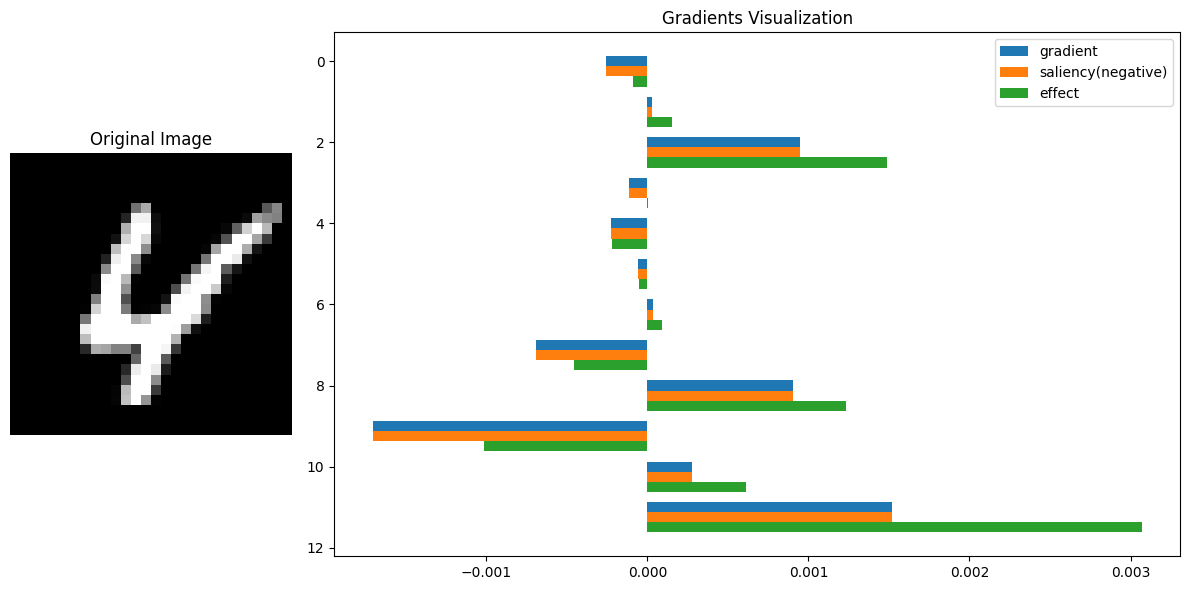

2024-04-19 11:34:13.022360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-19 11:34:13.073136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


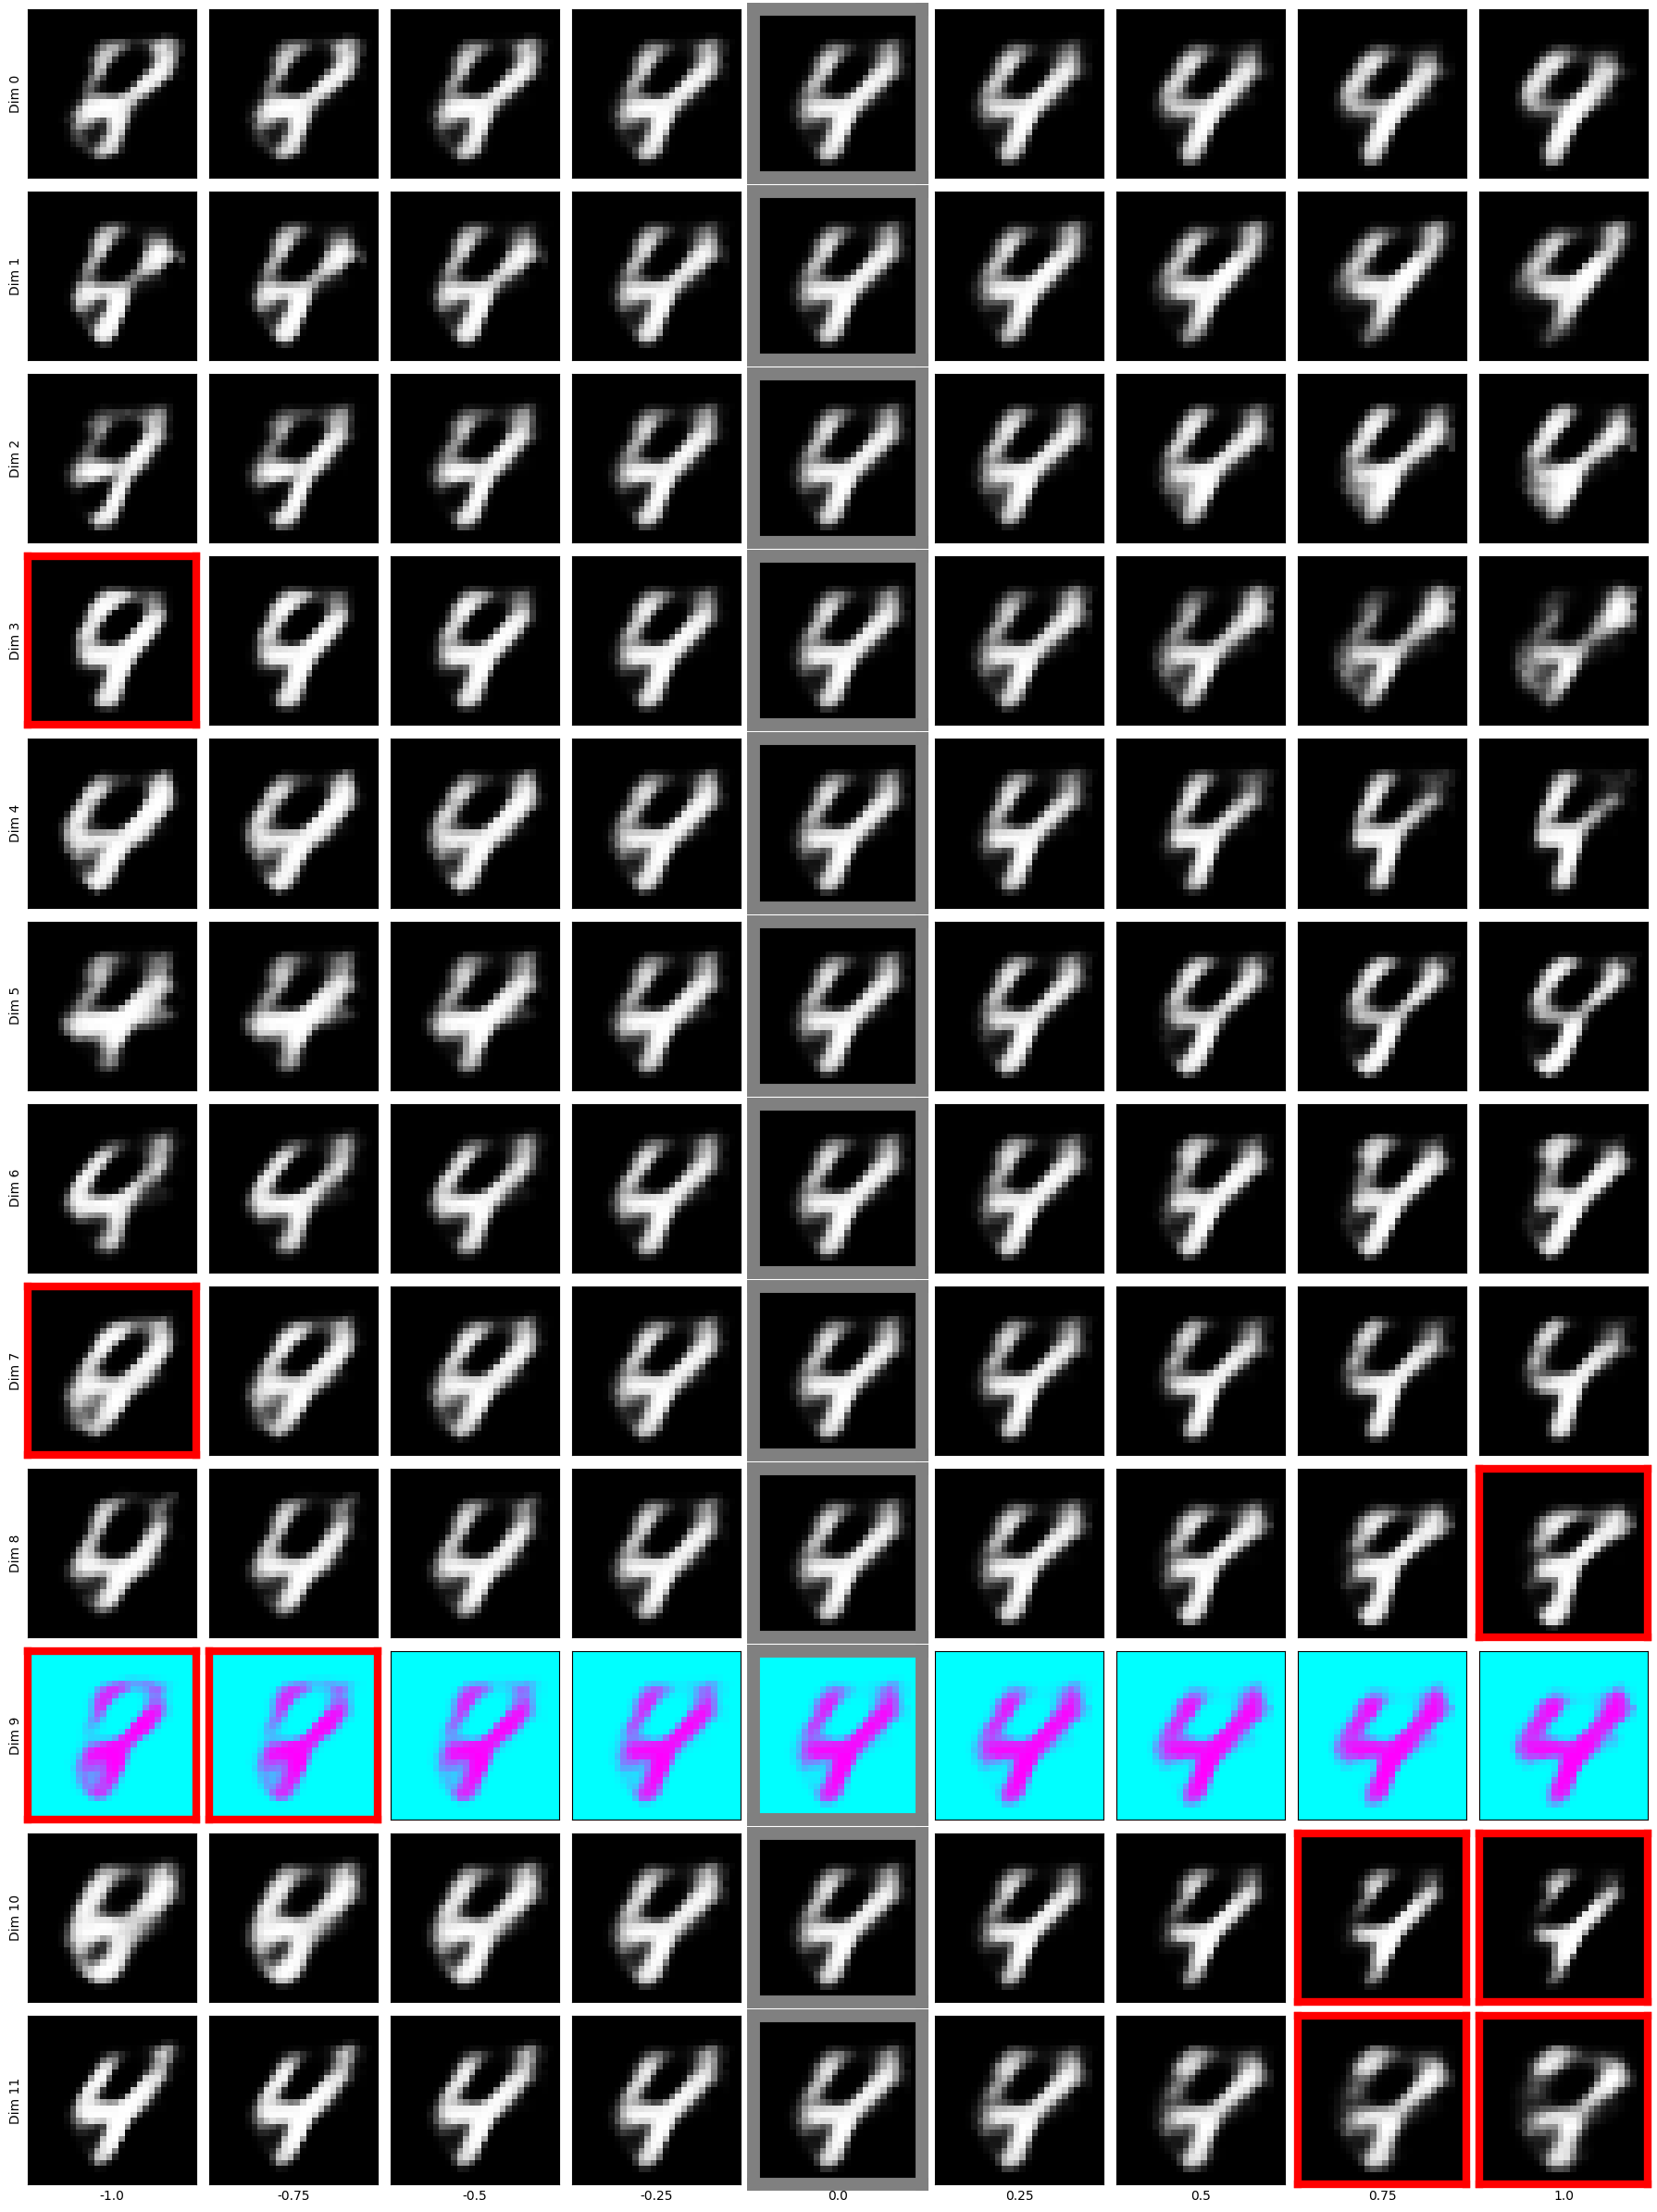

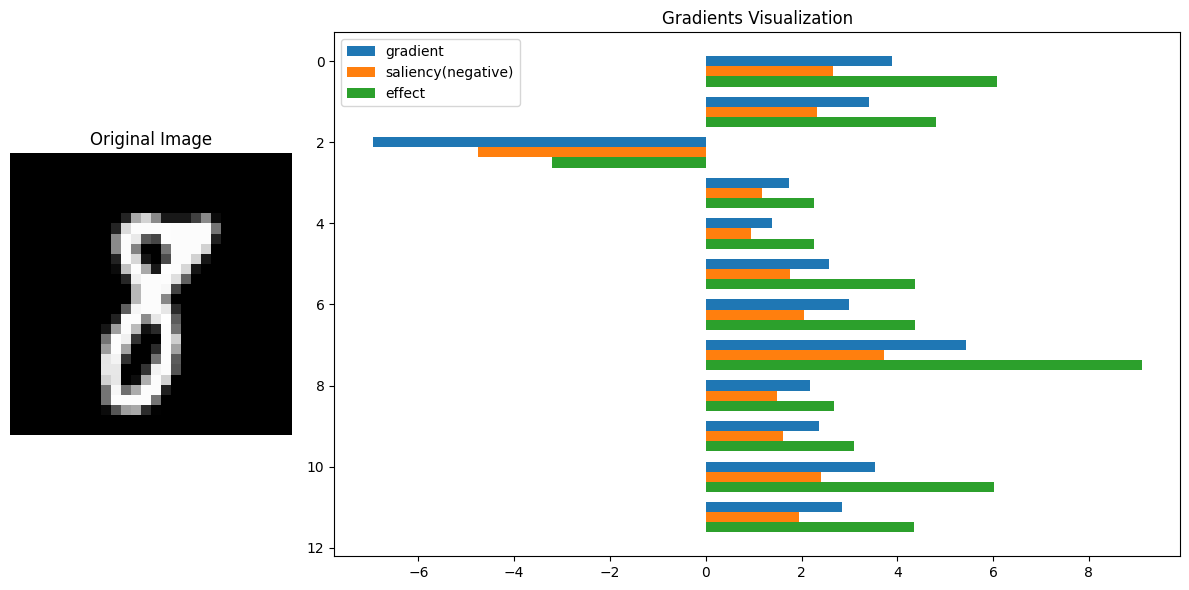

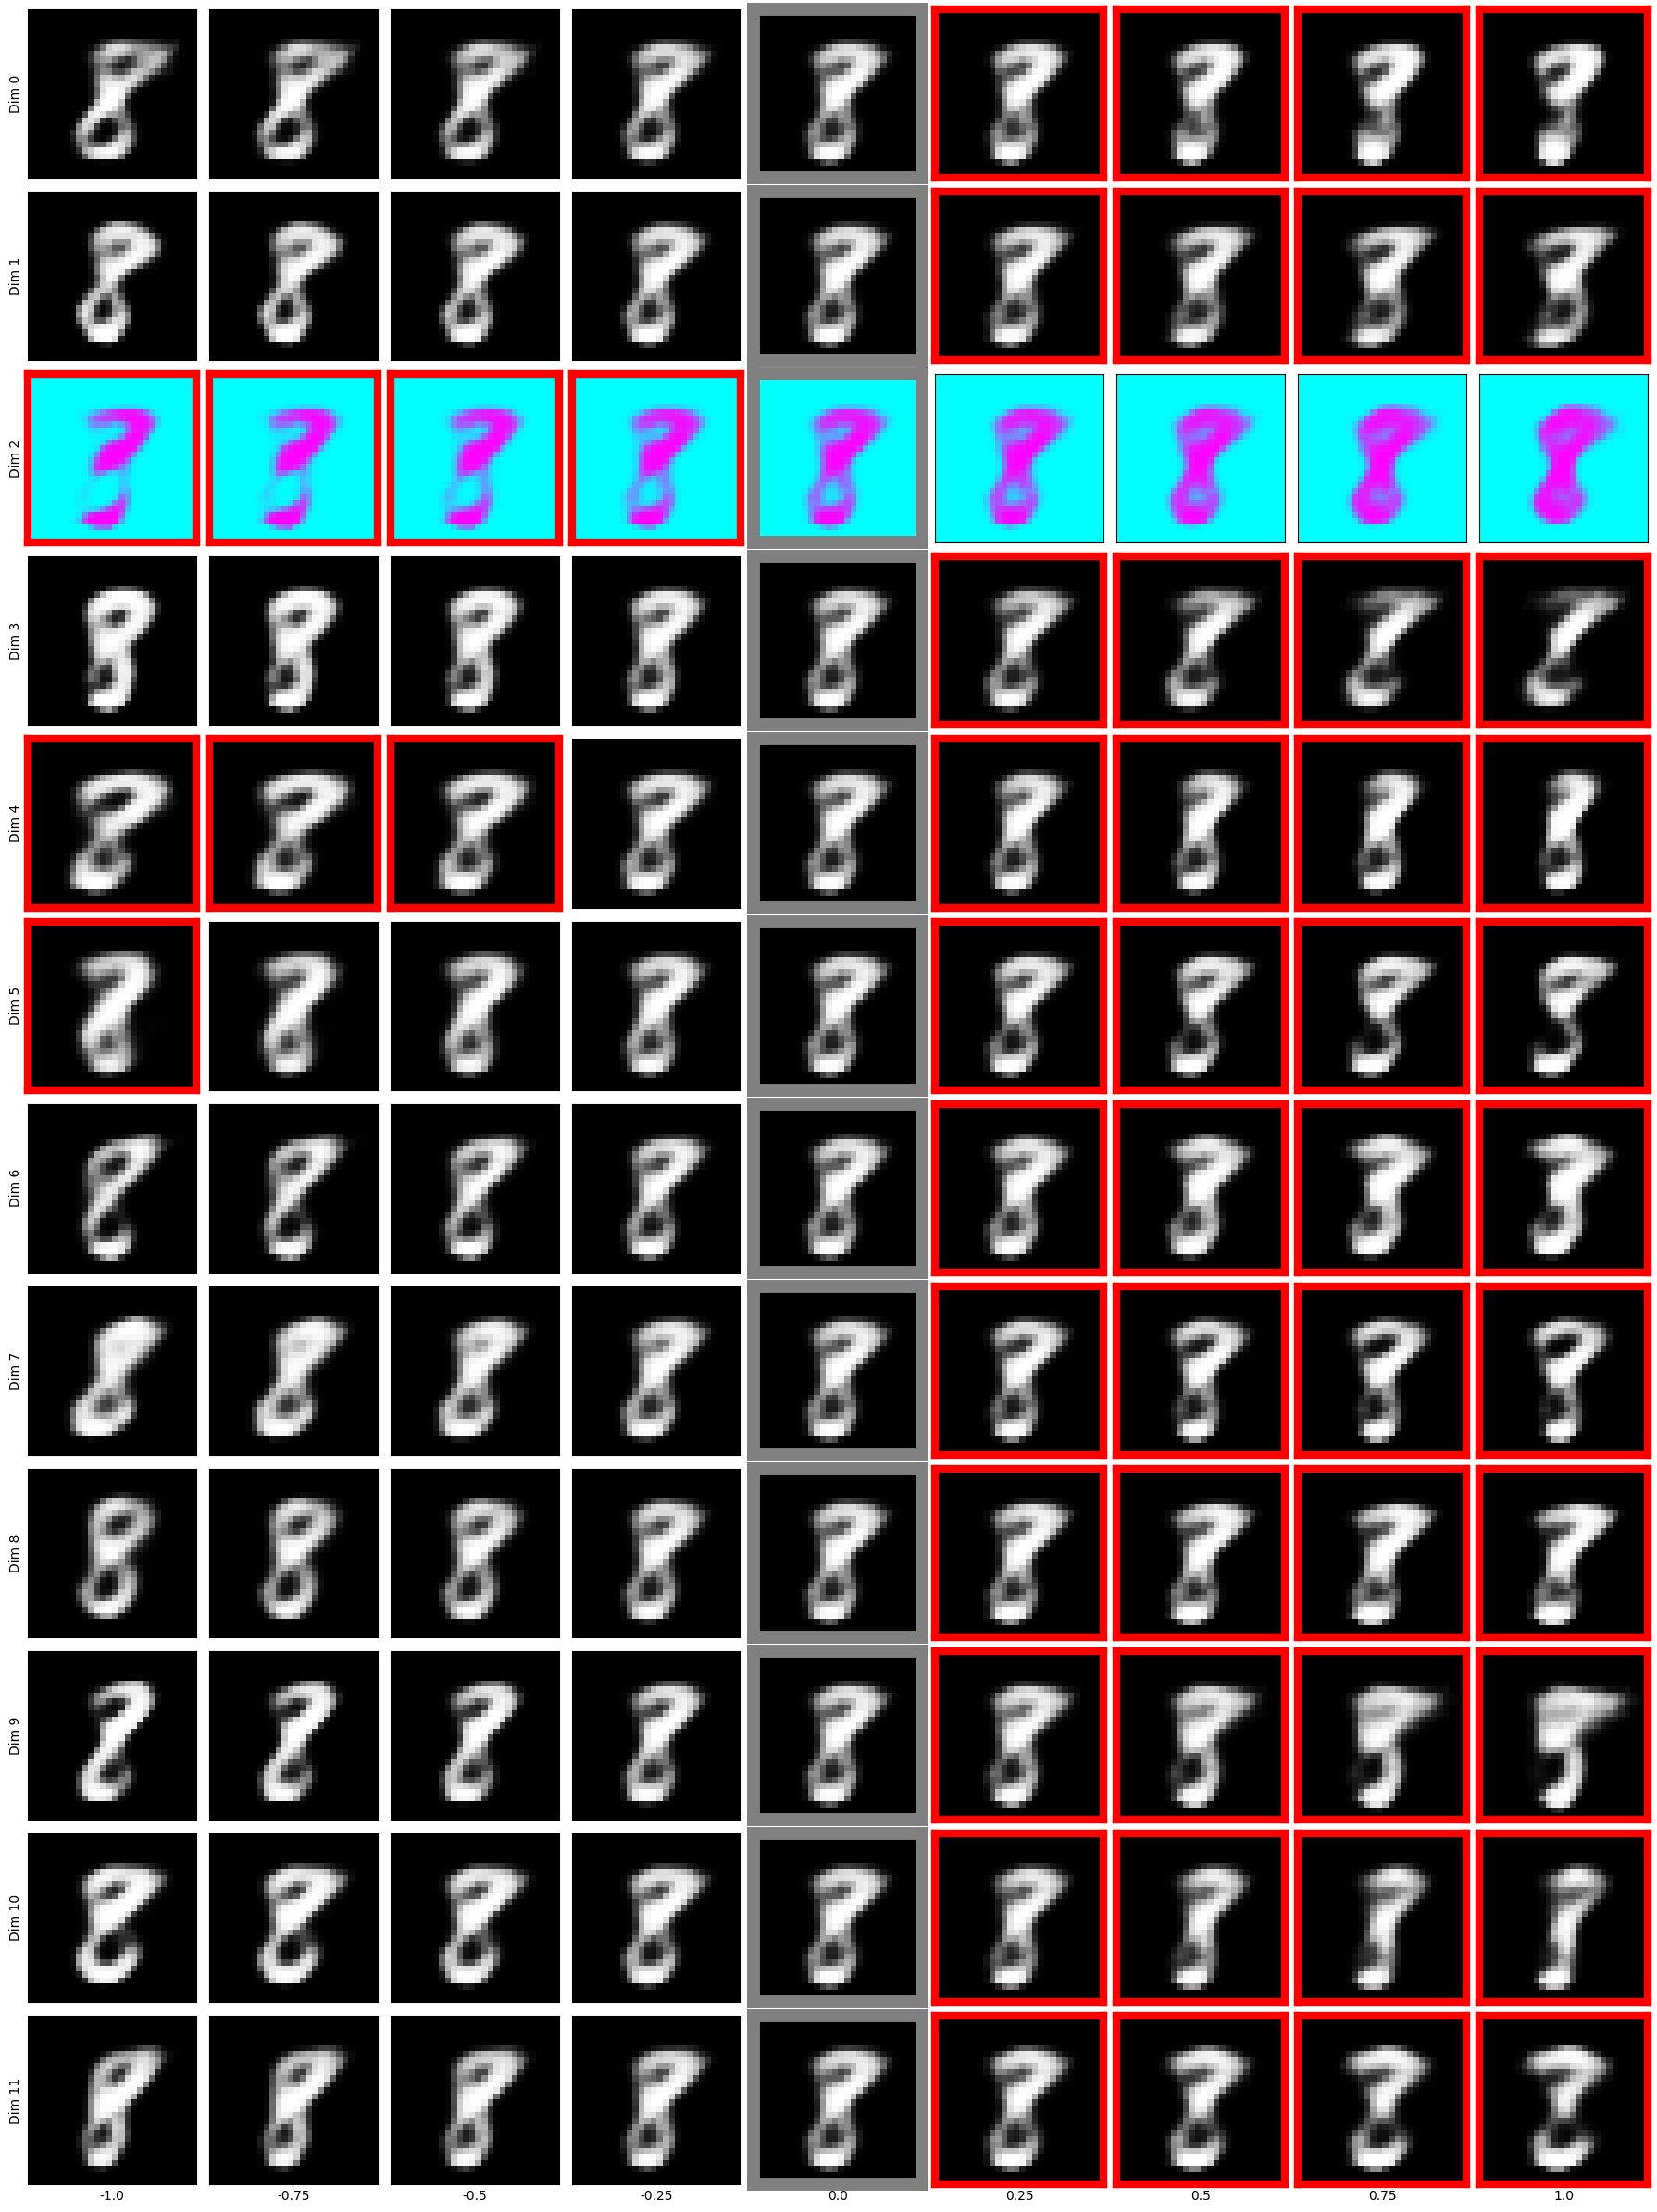

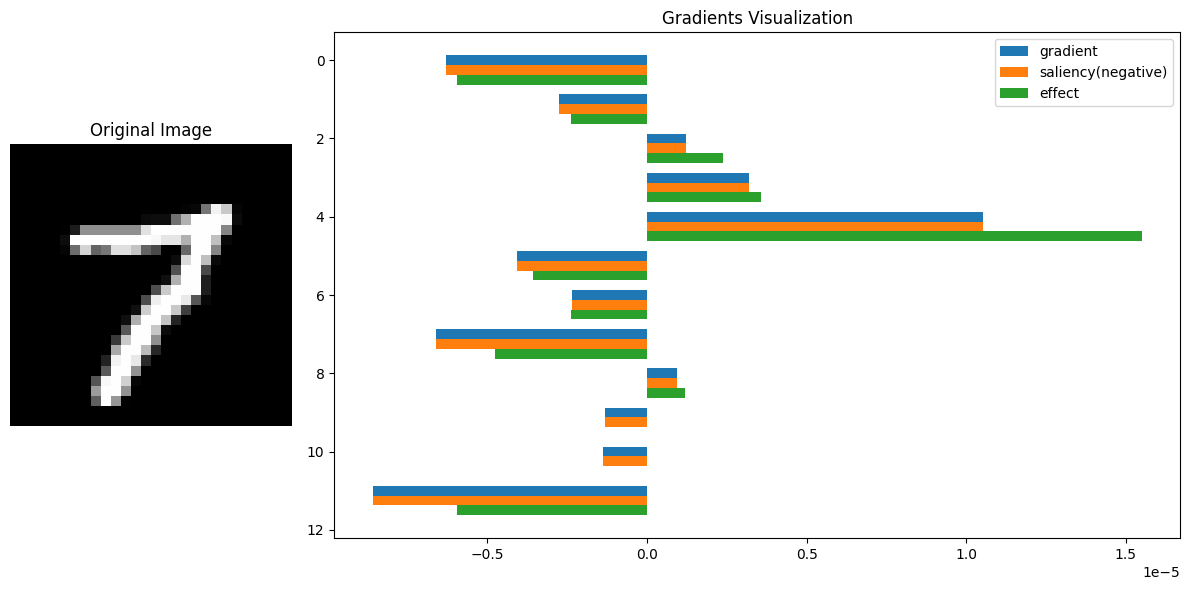

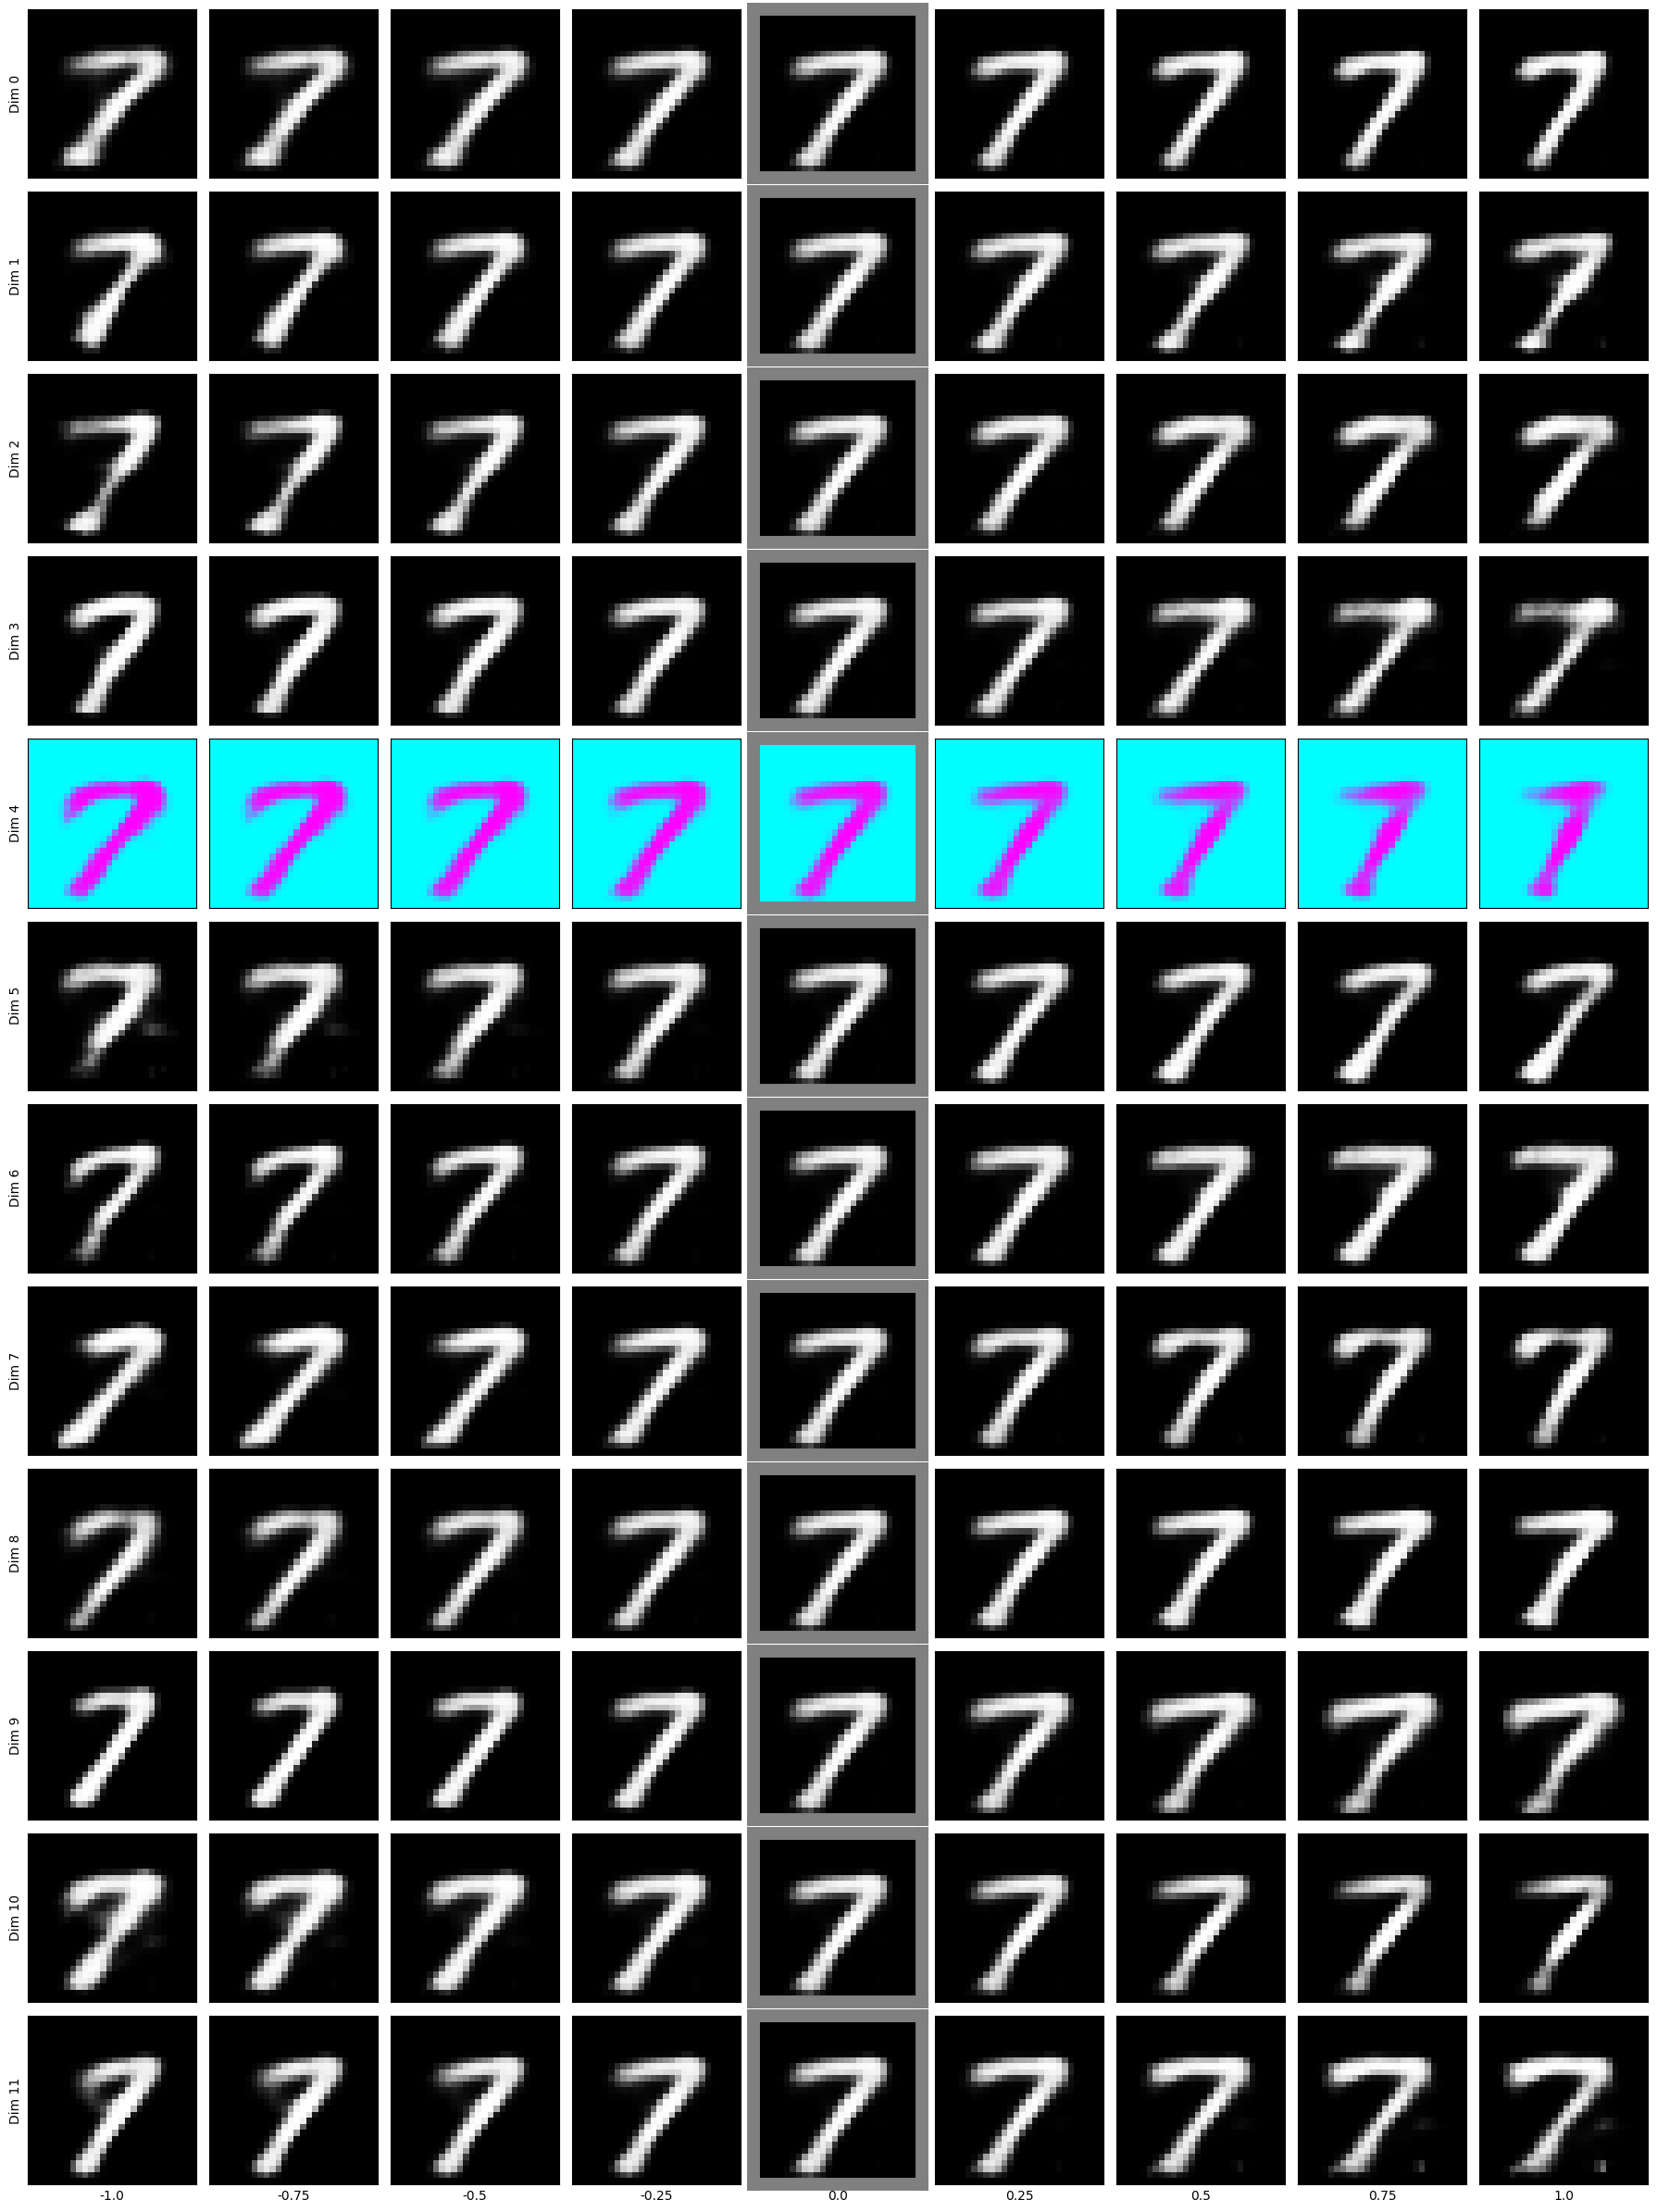

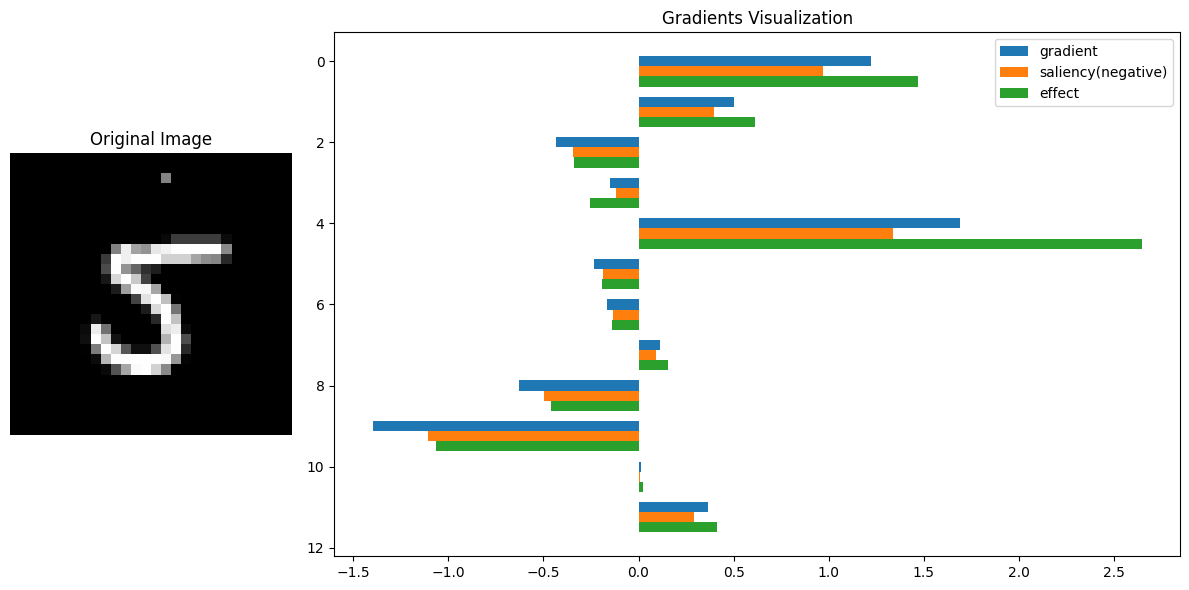

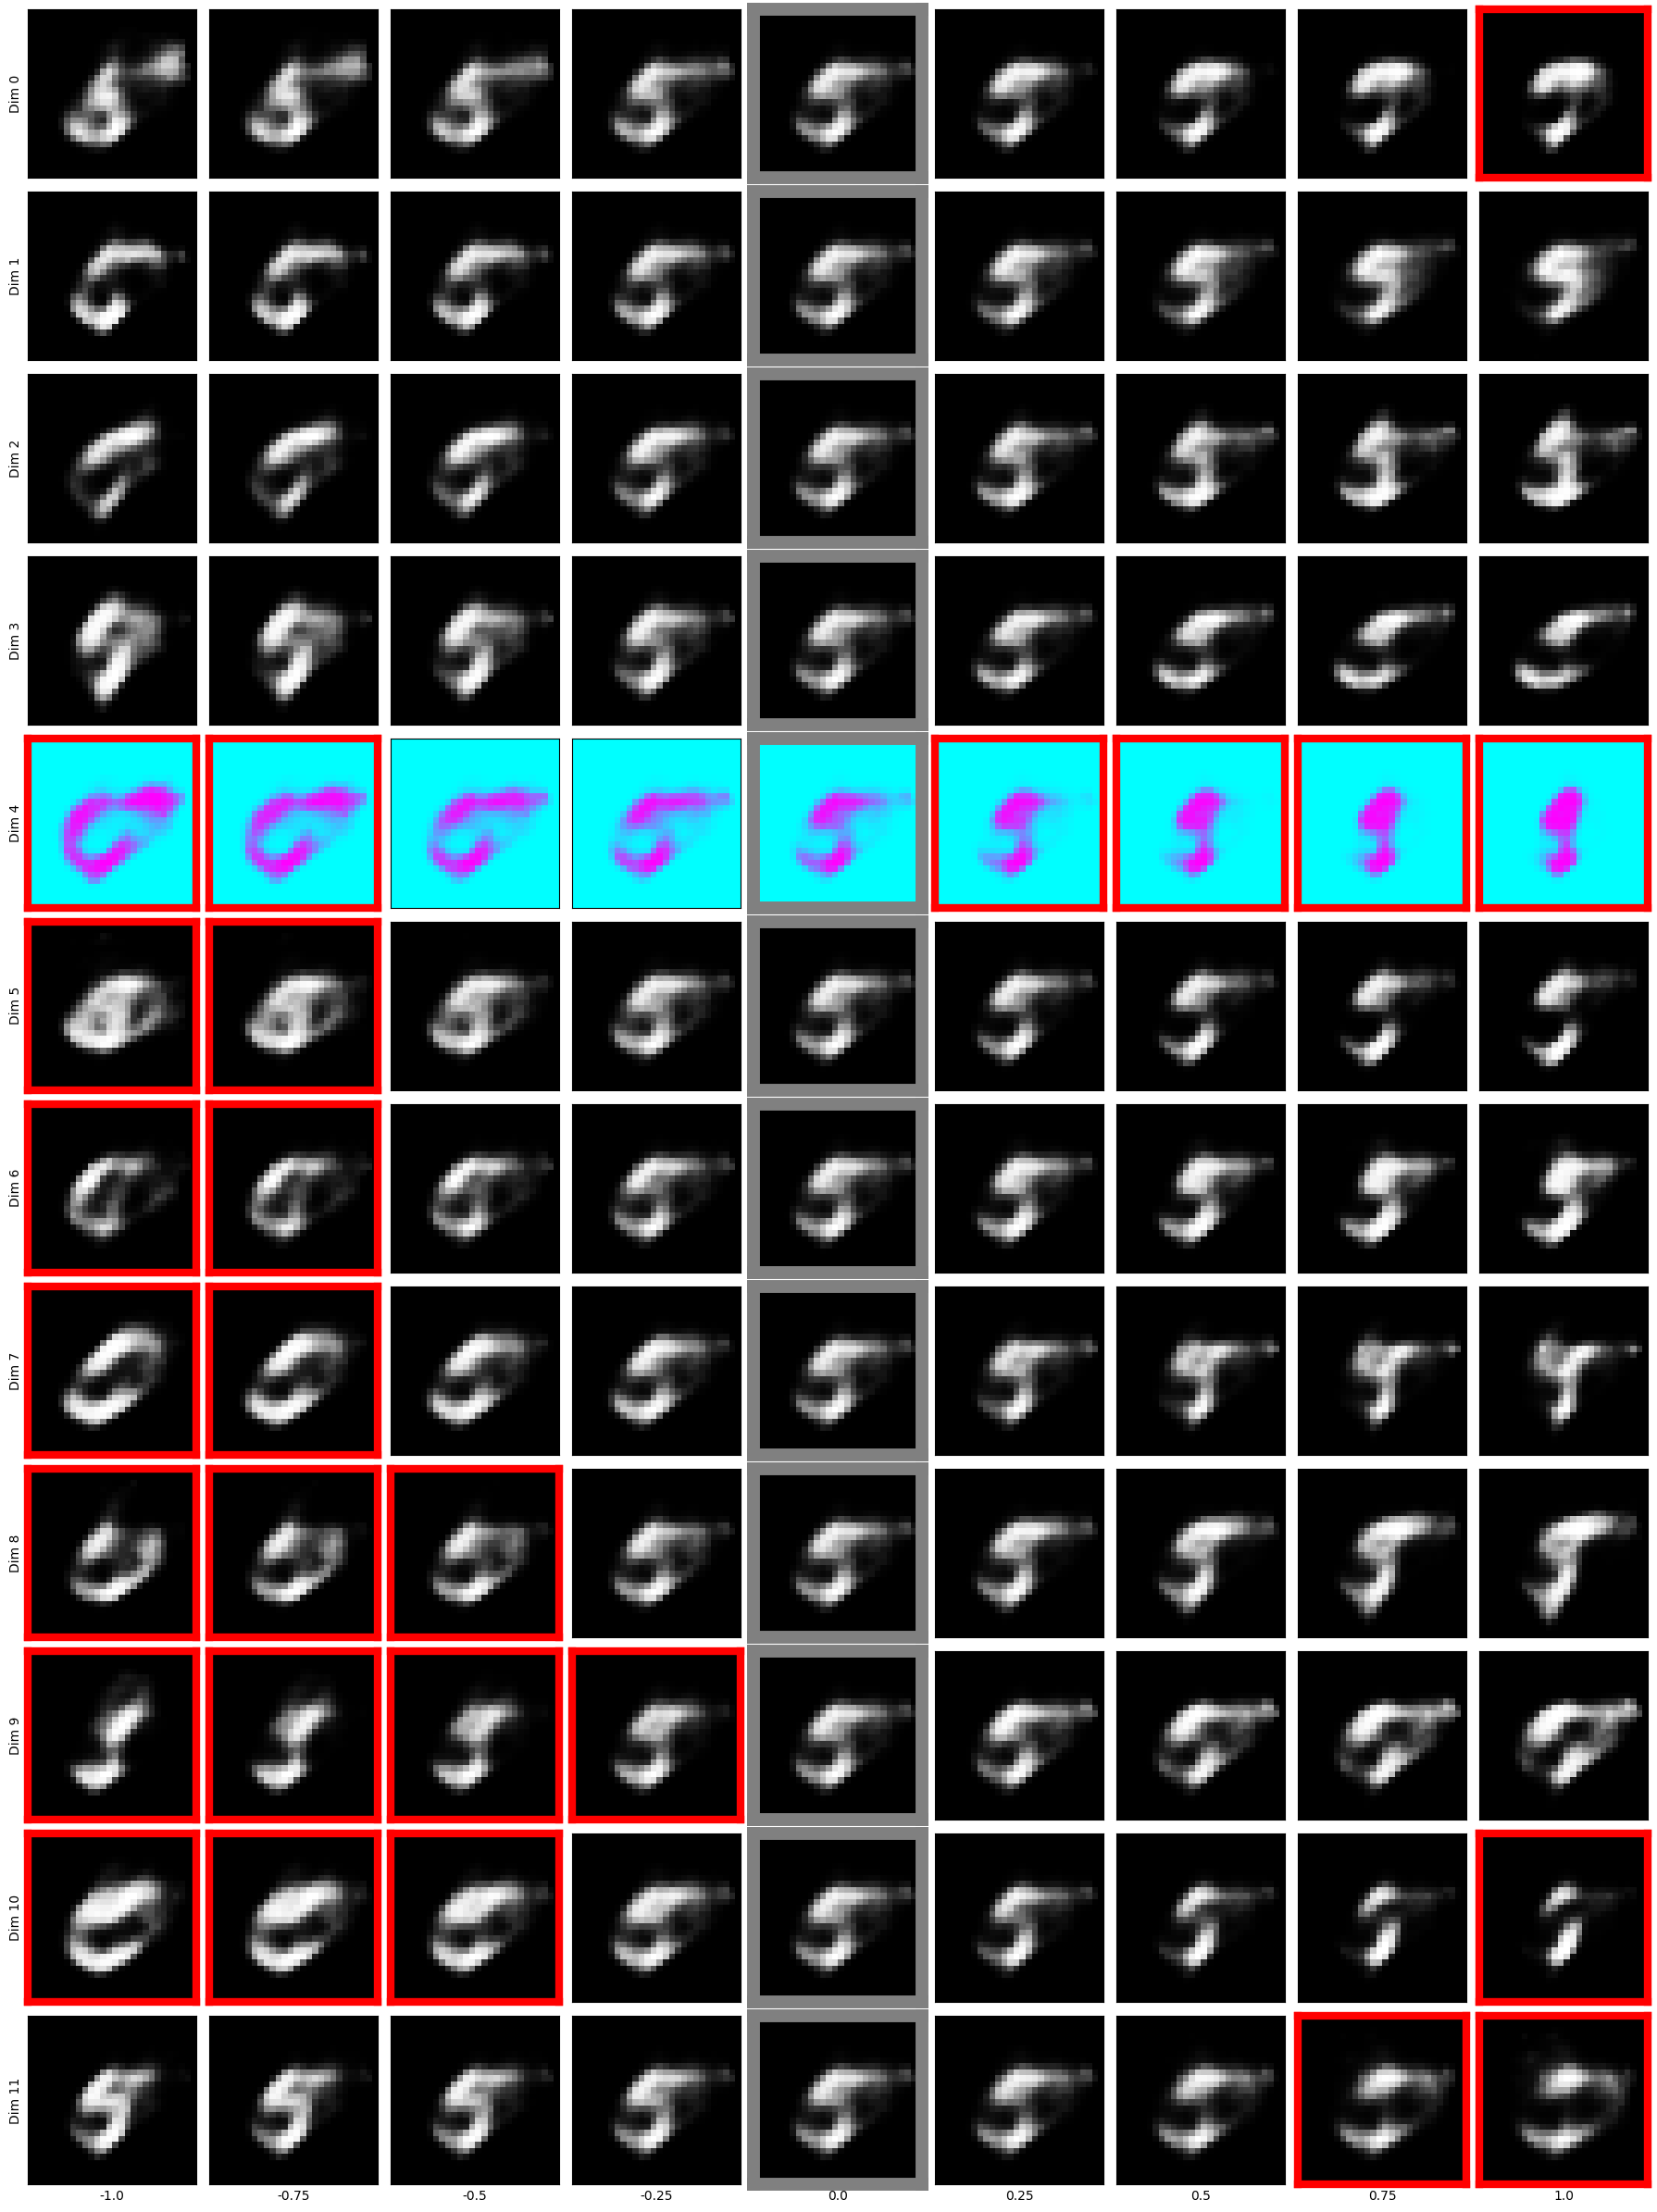

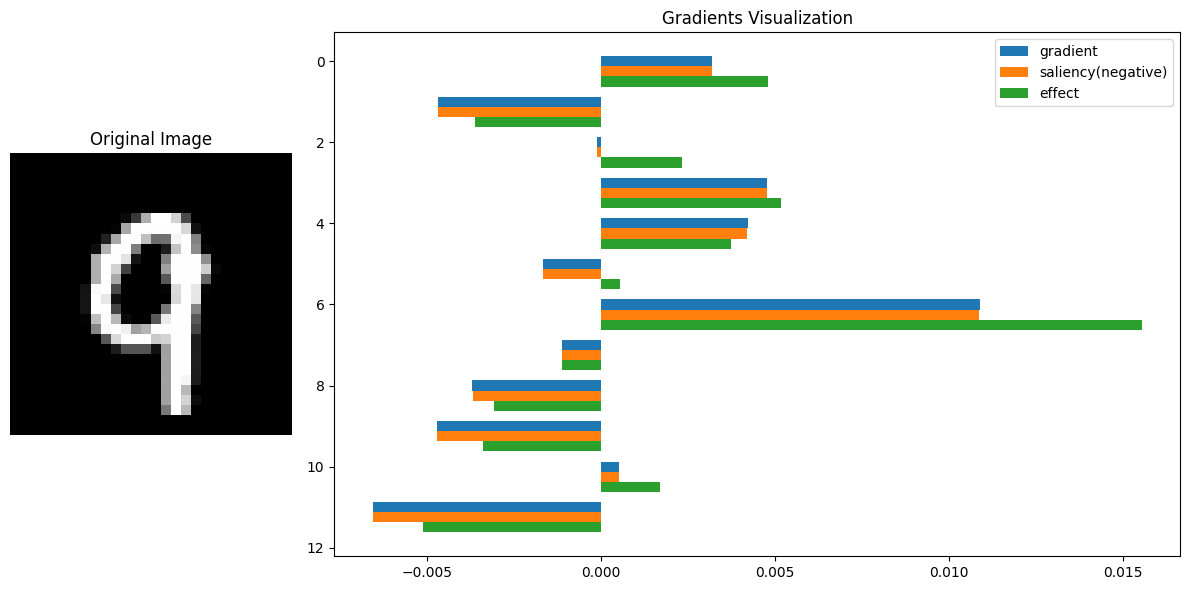

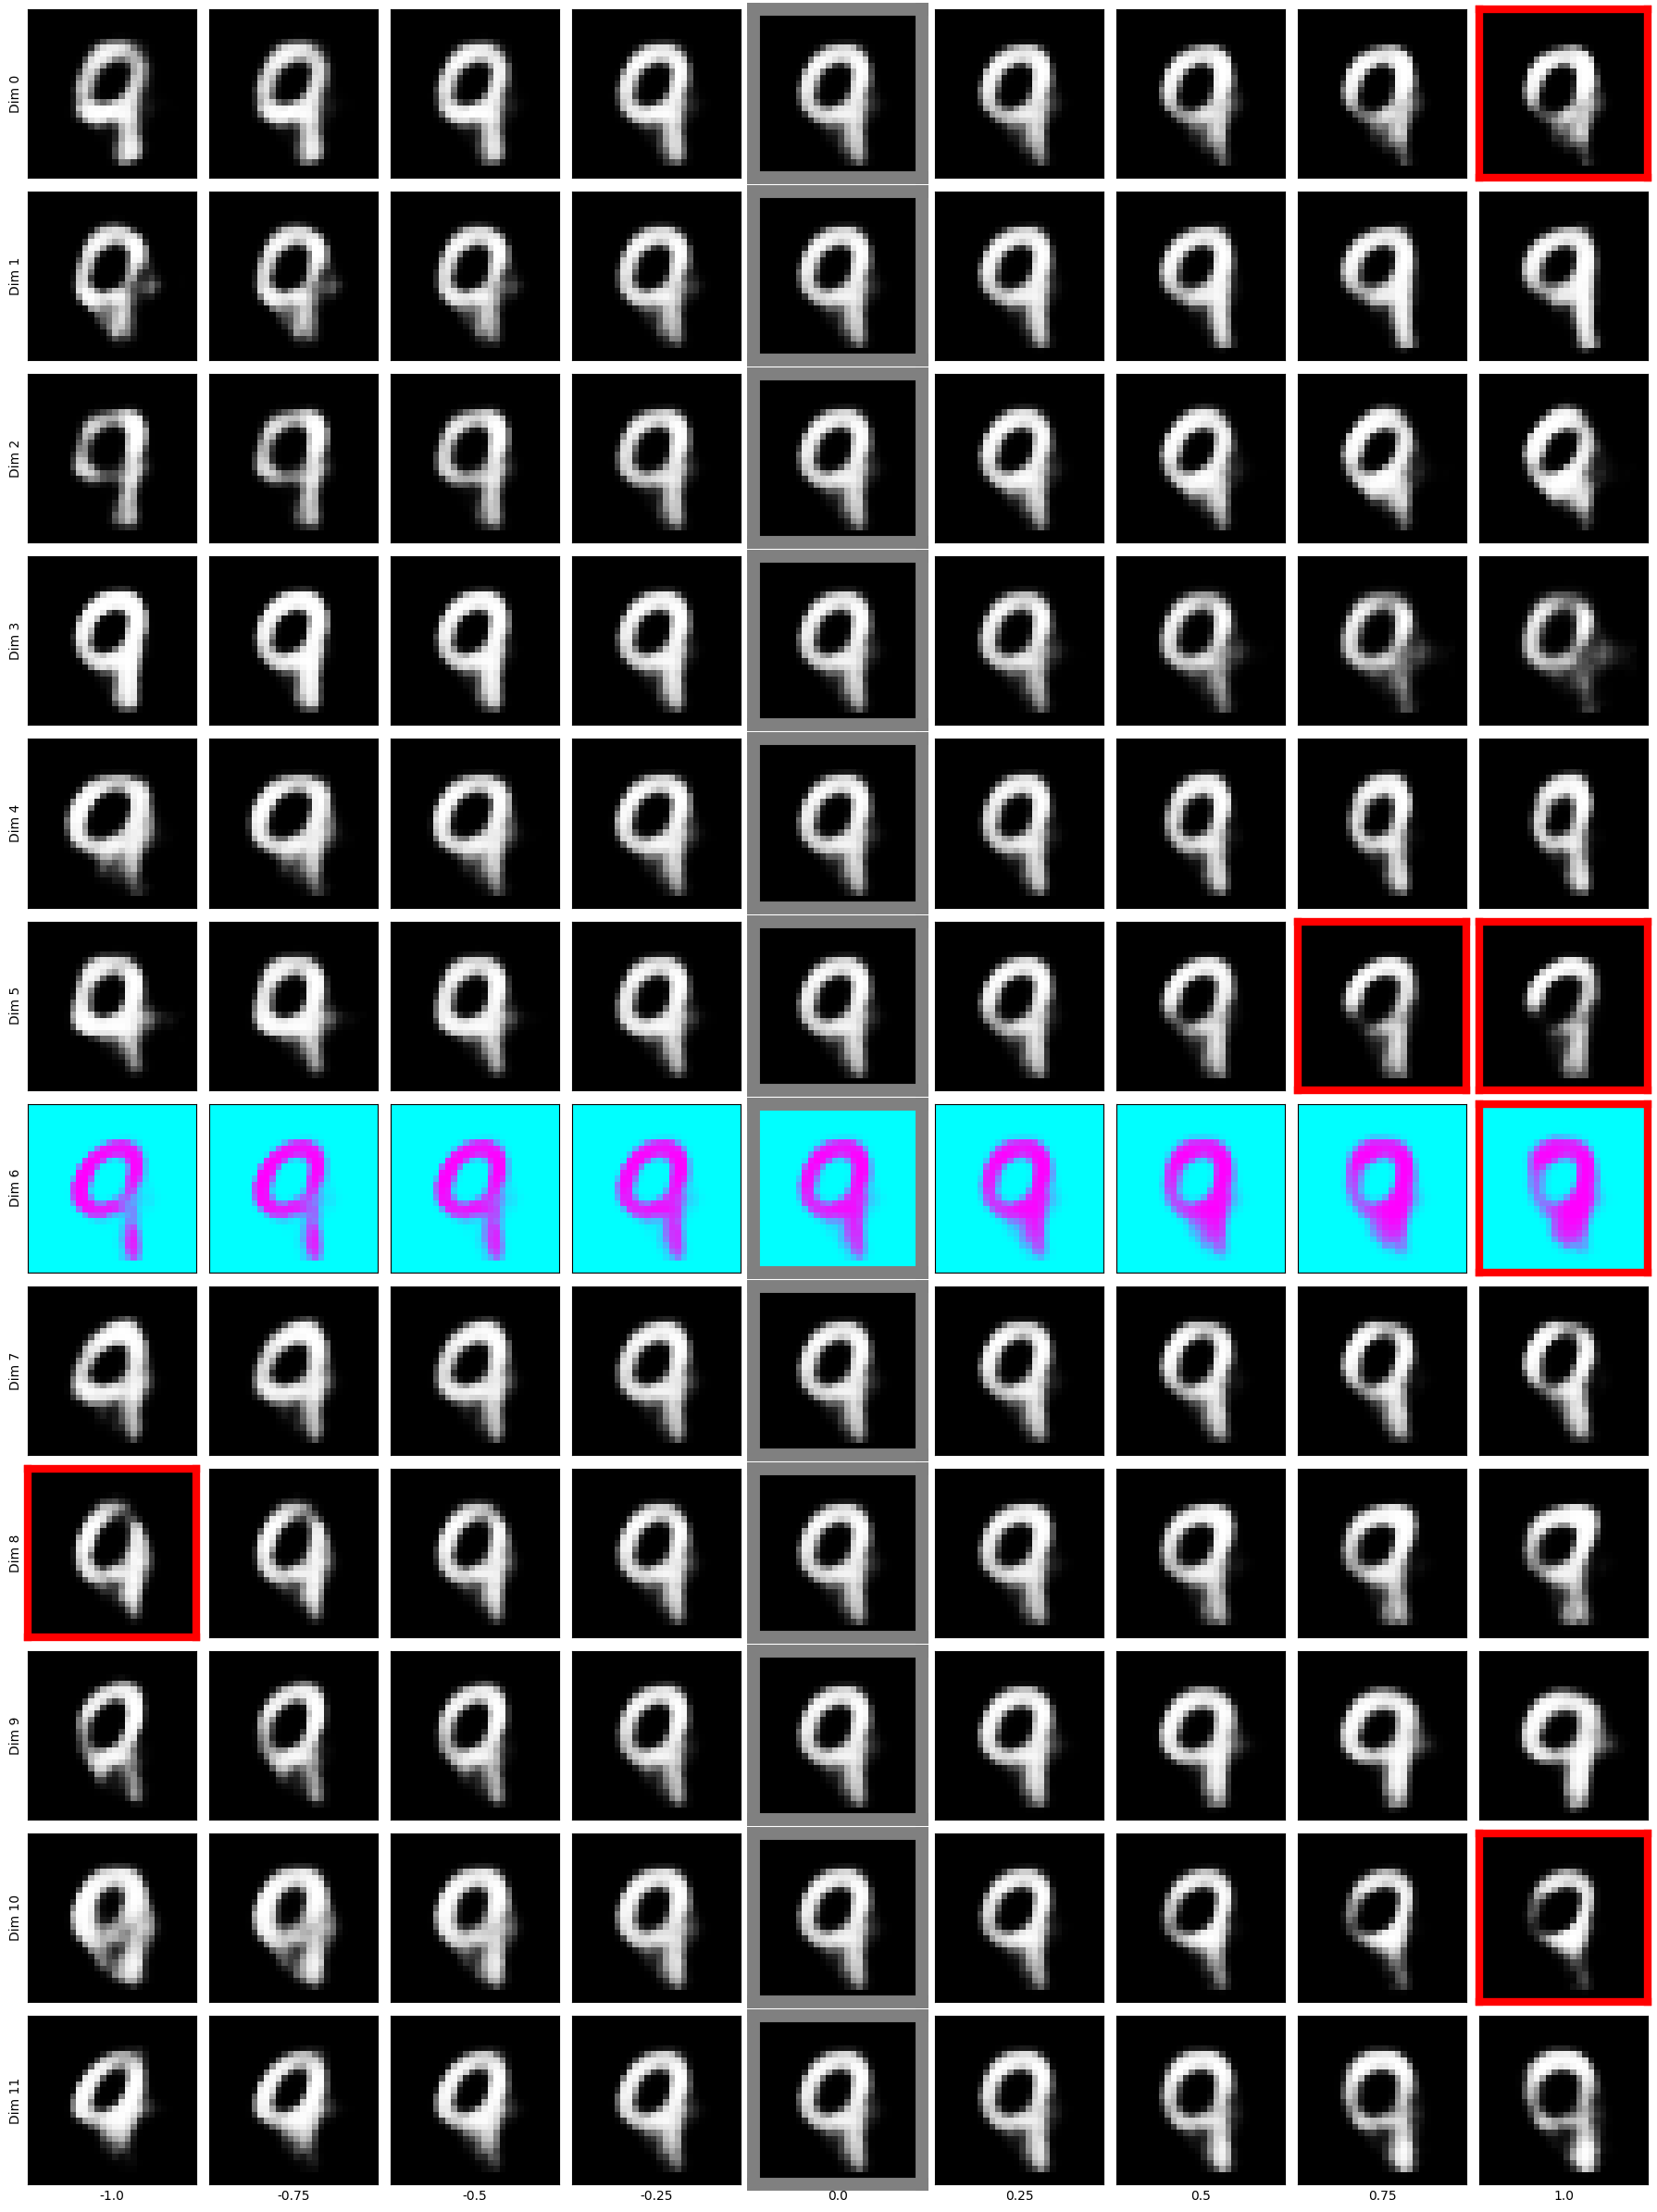

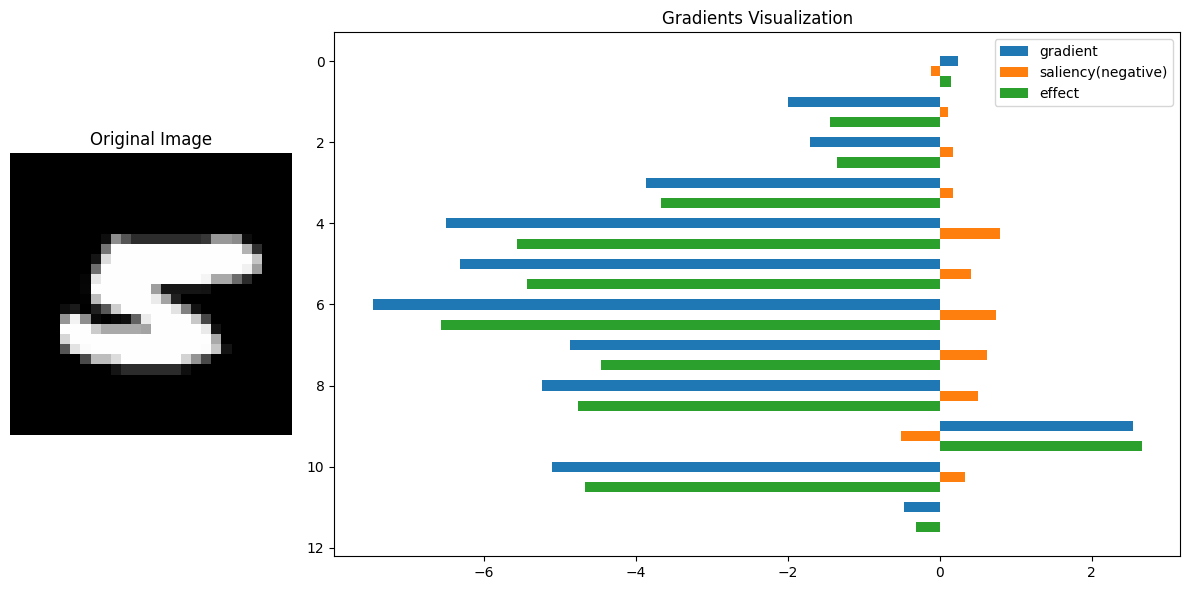

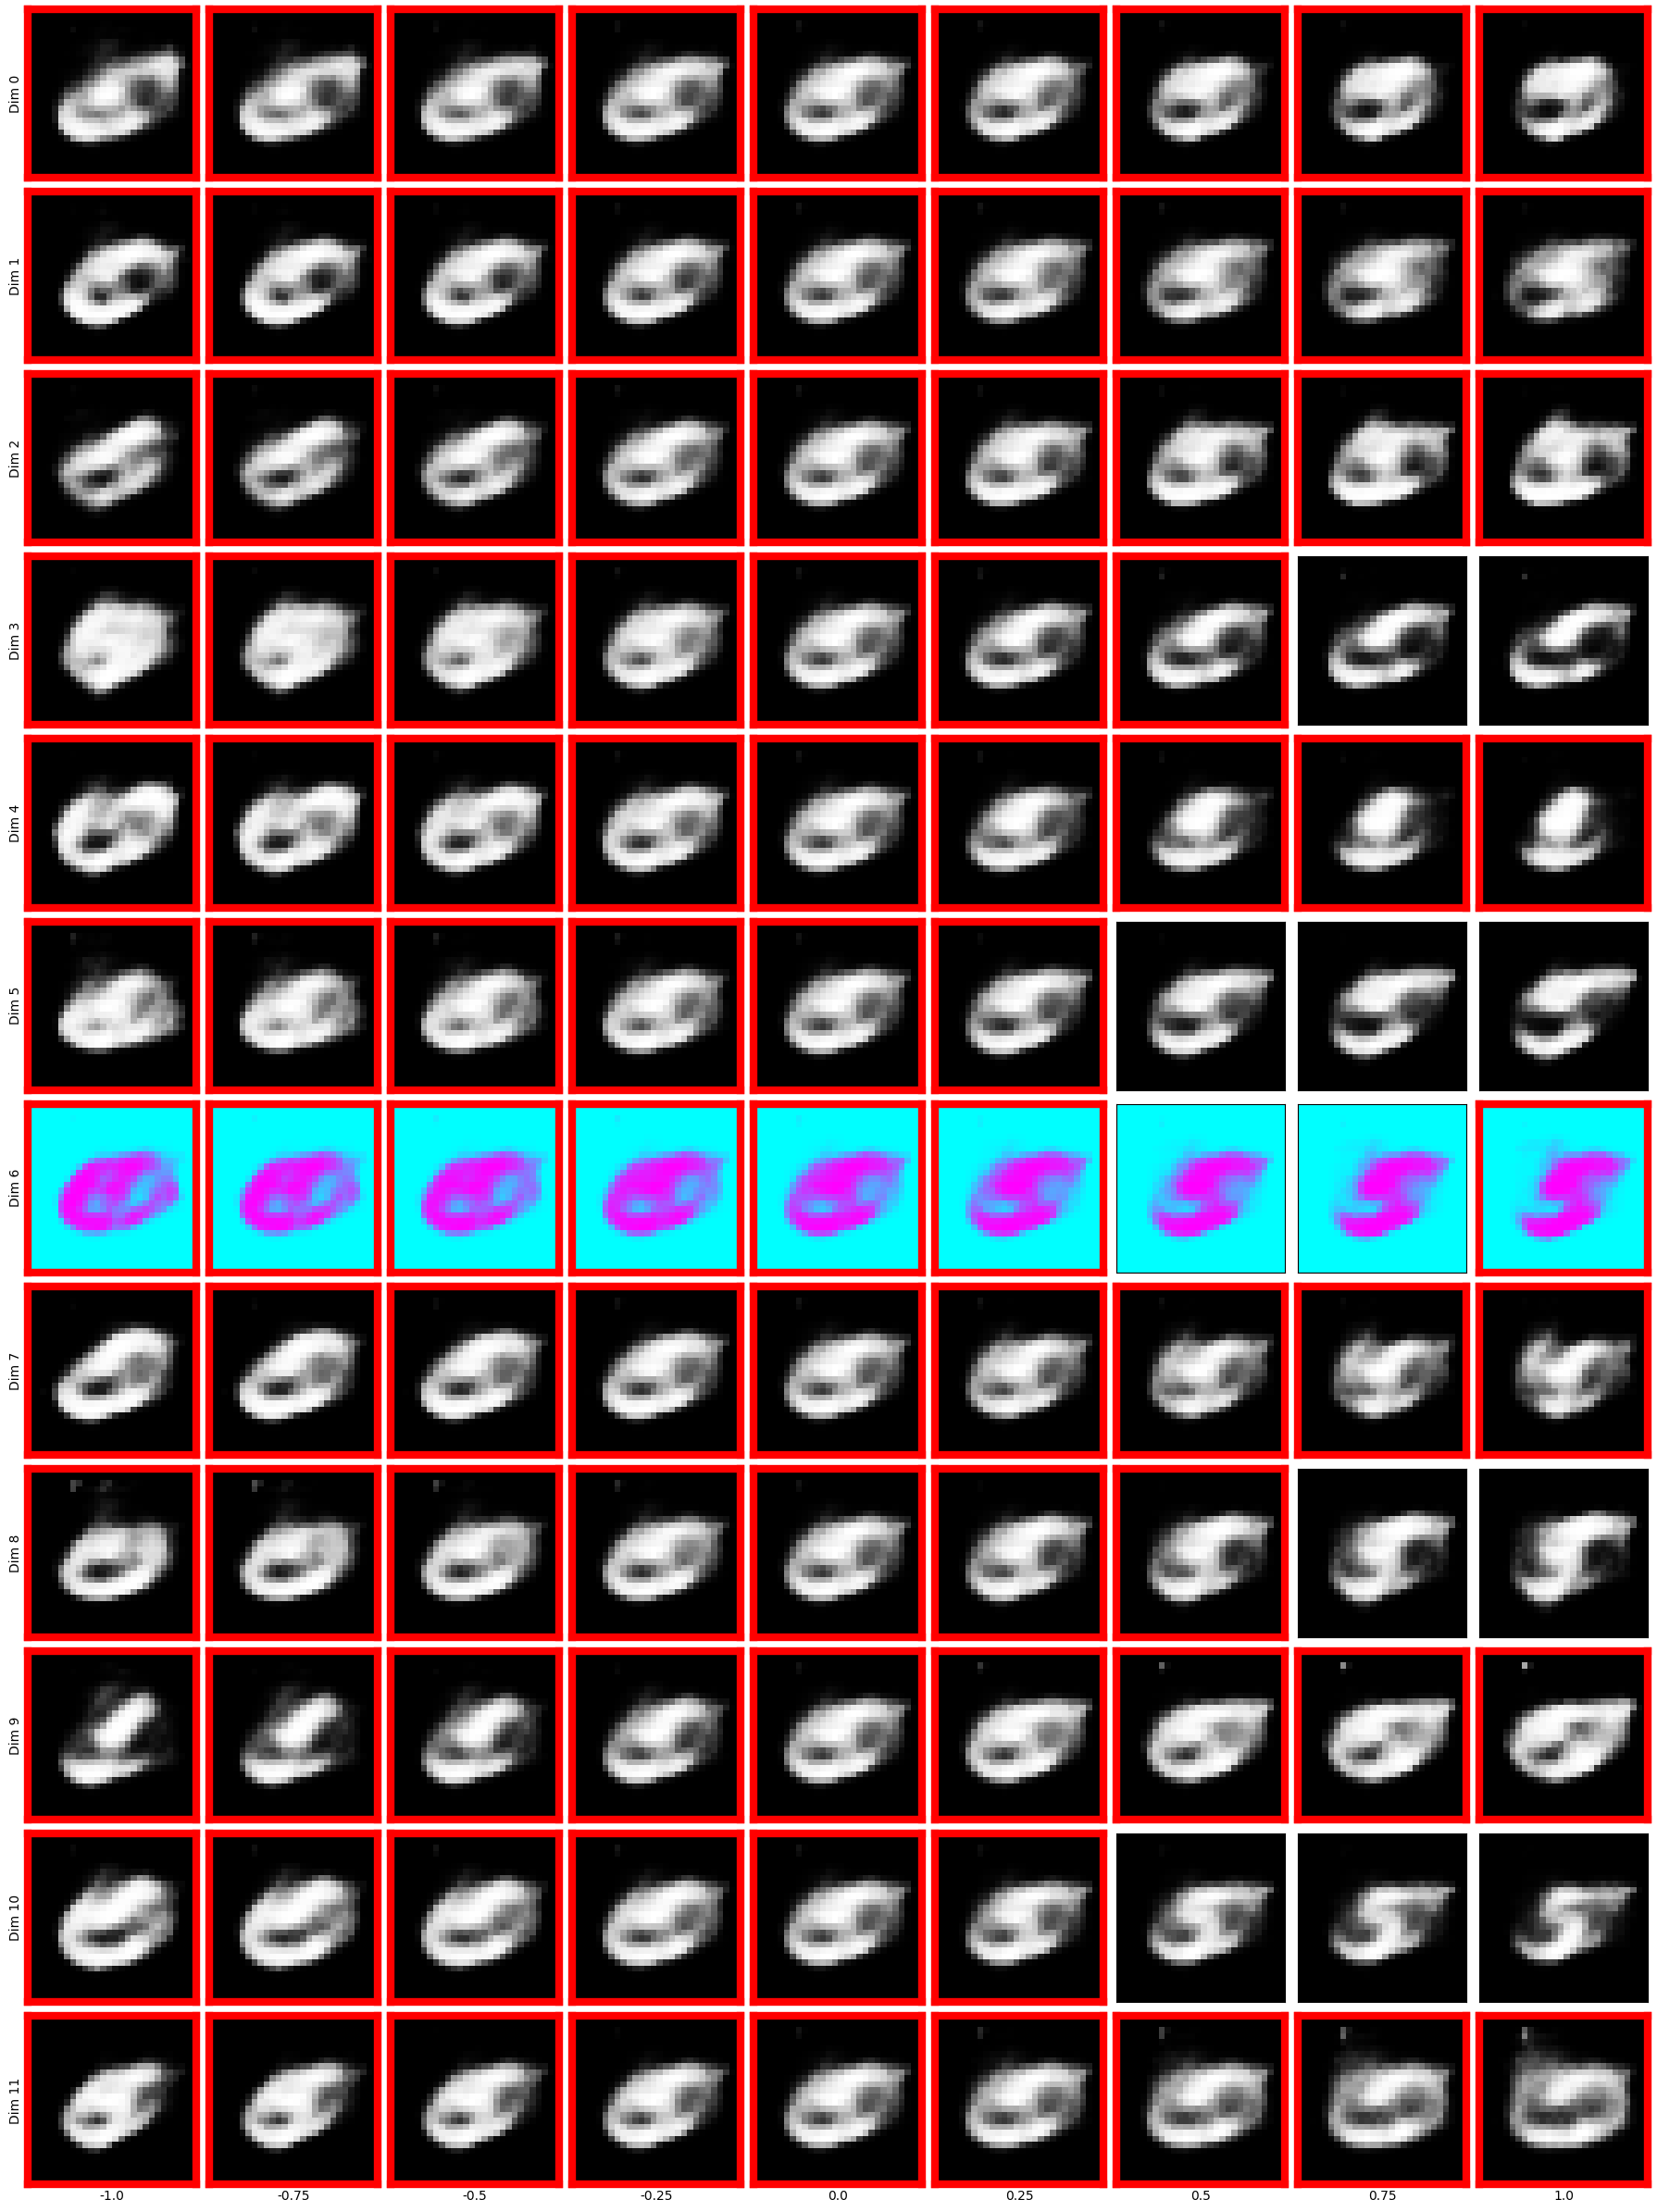

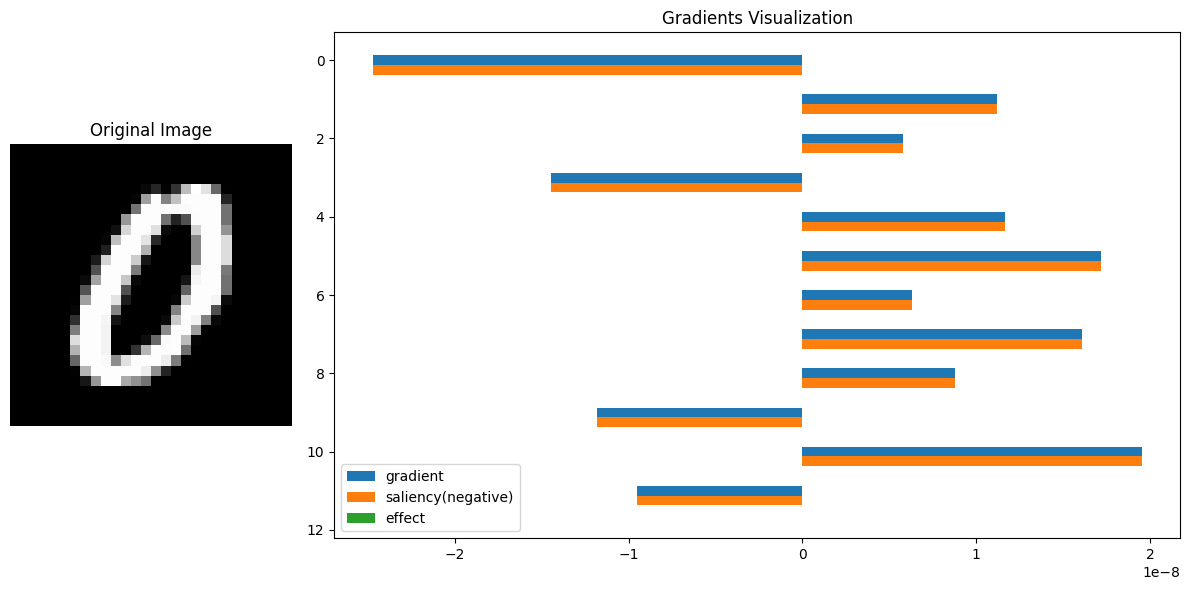

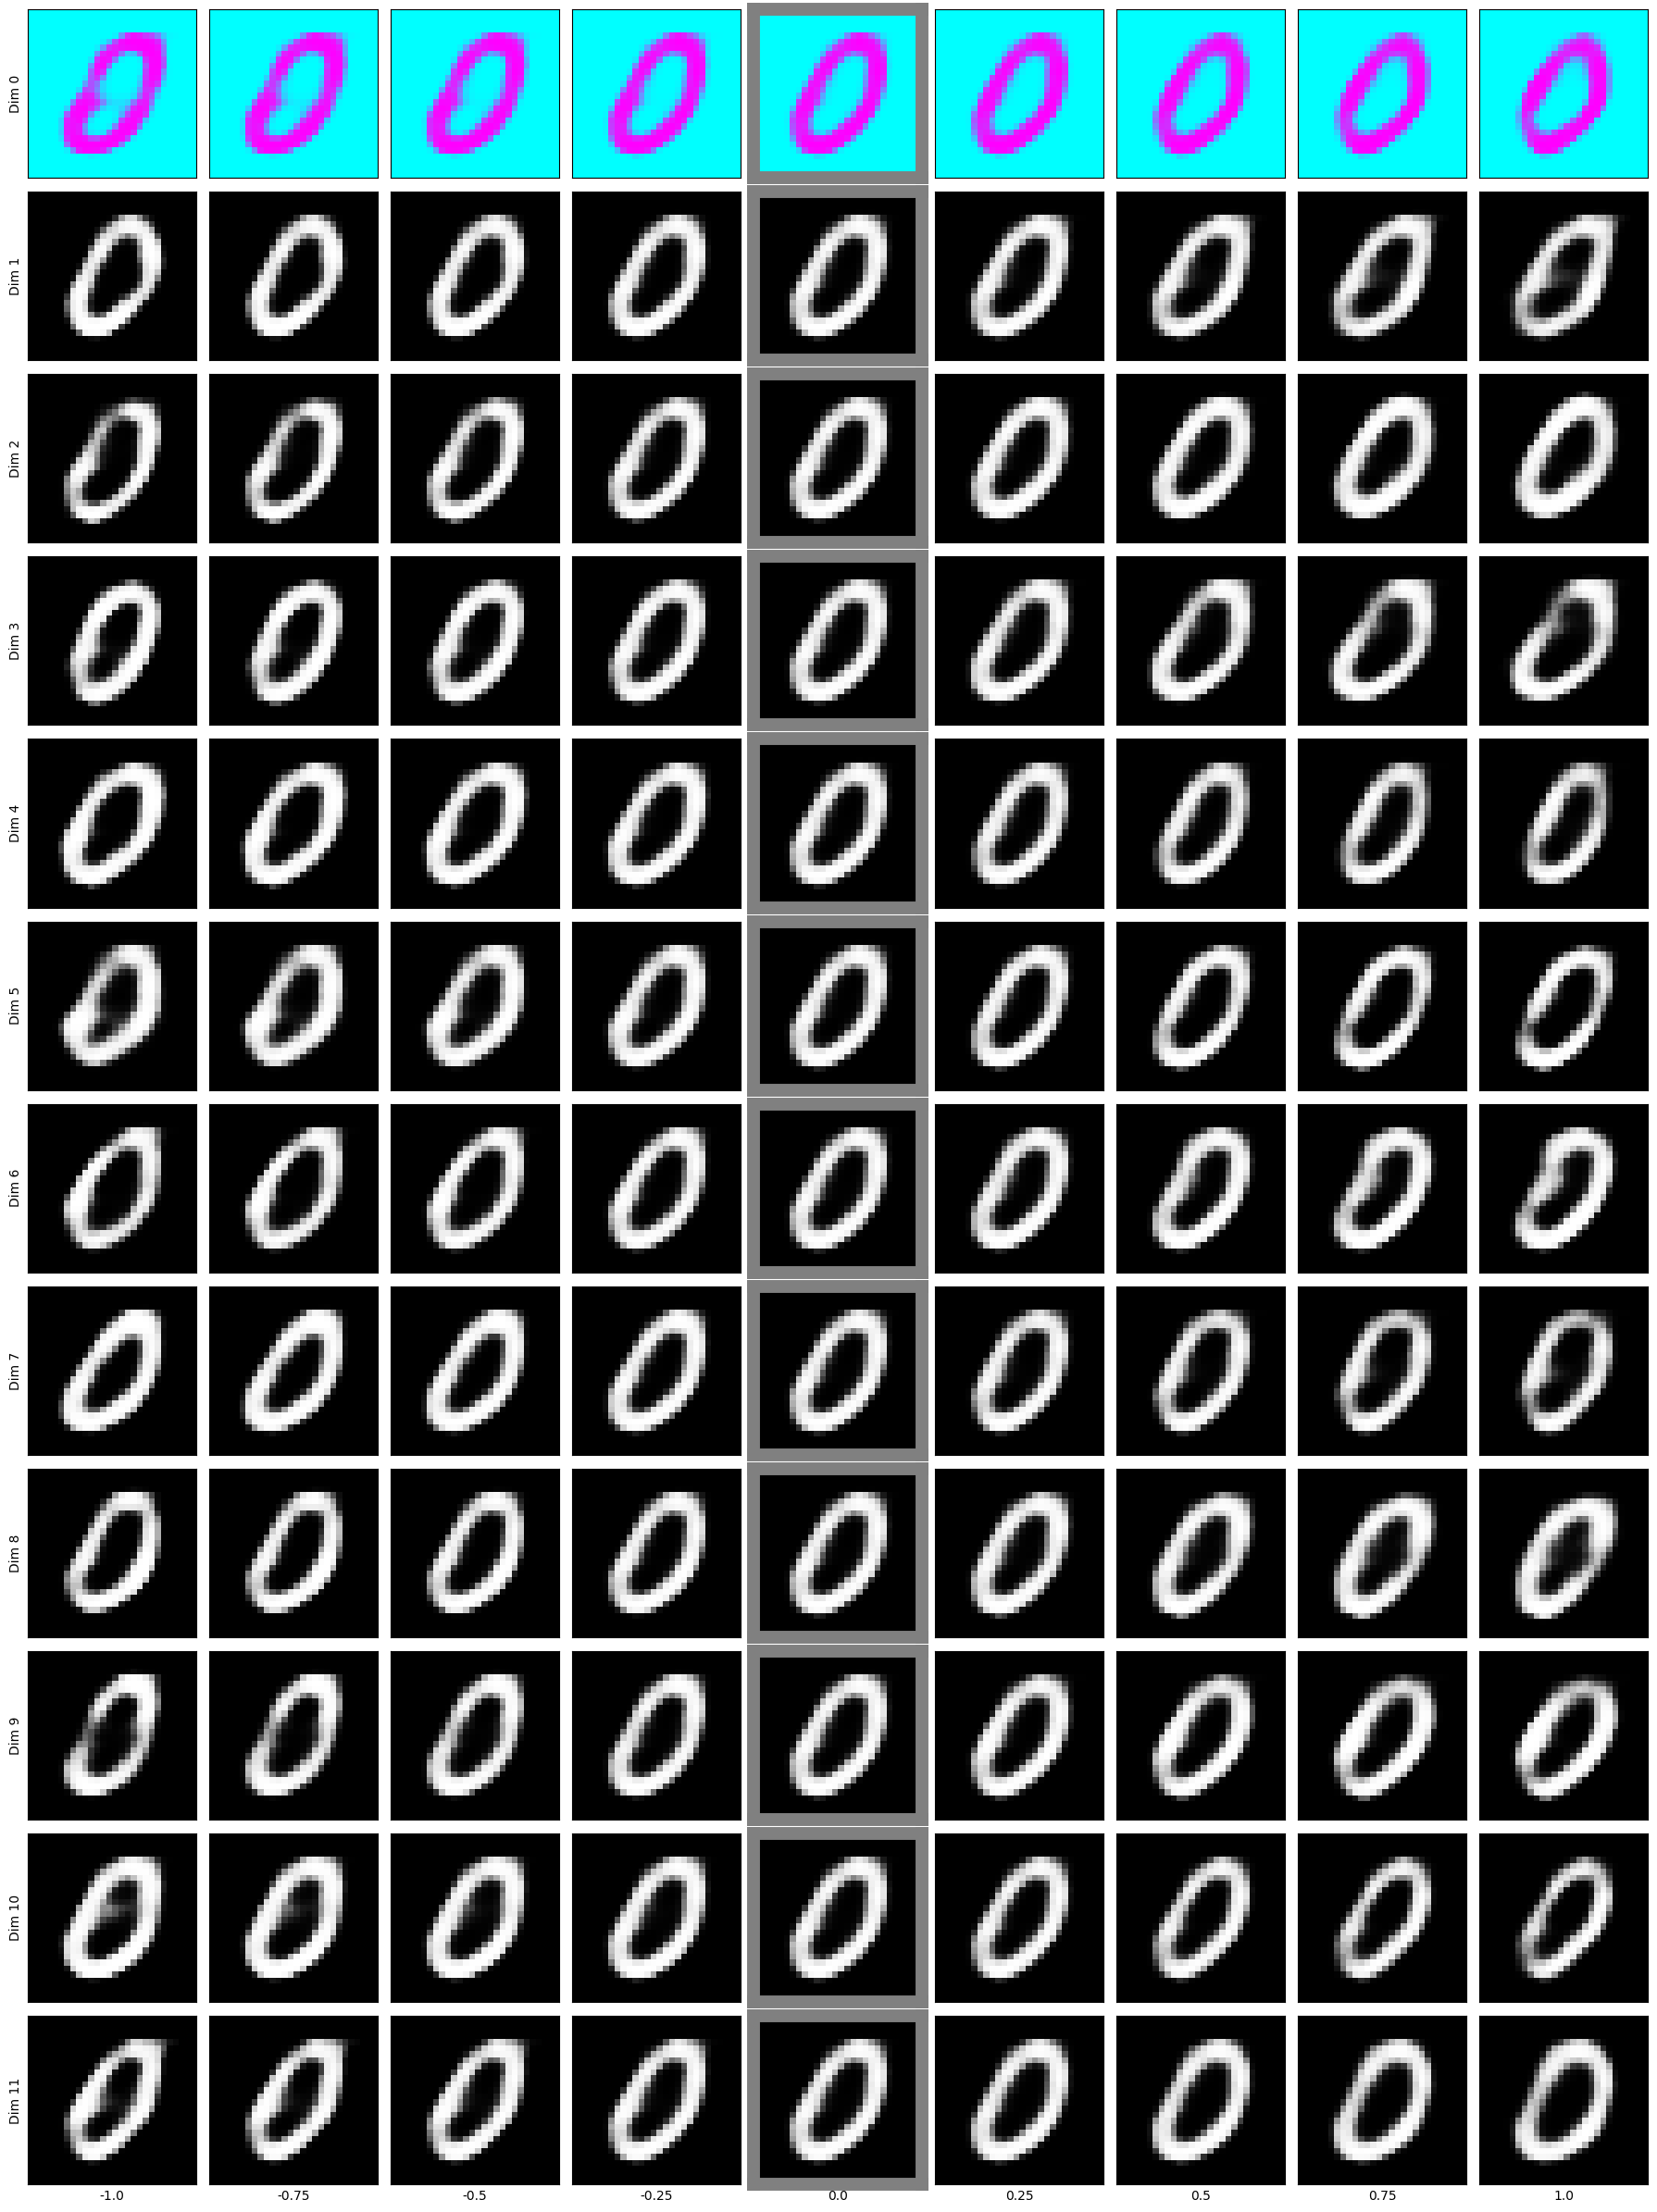

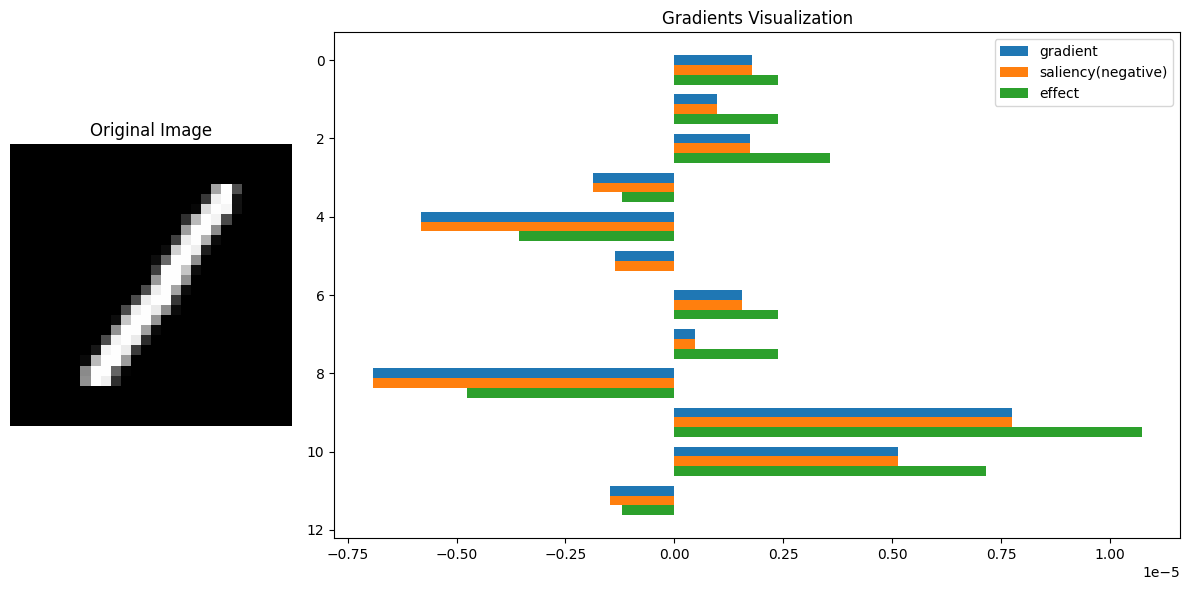

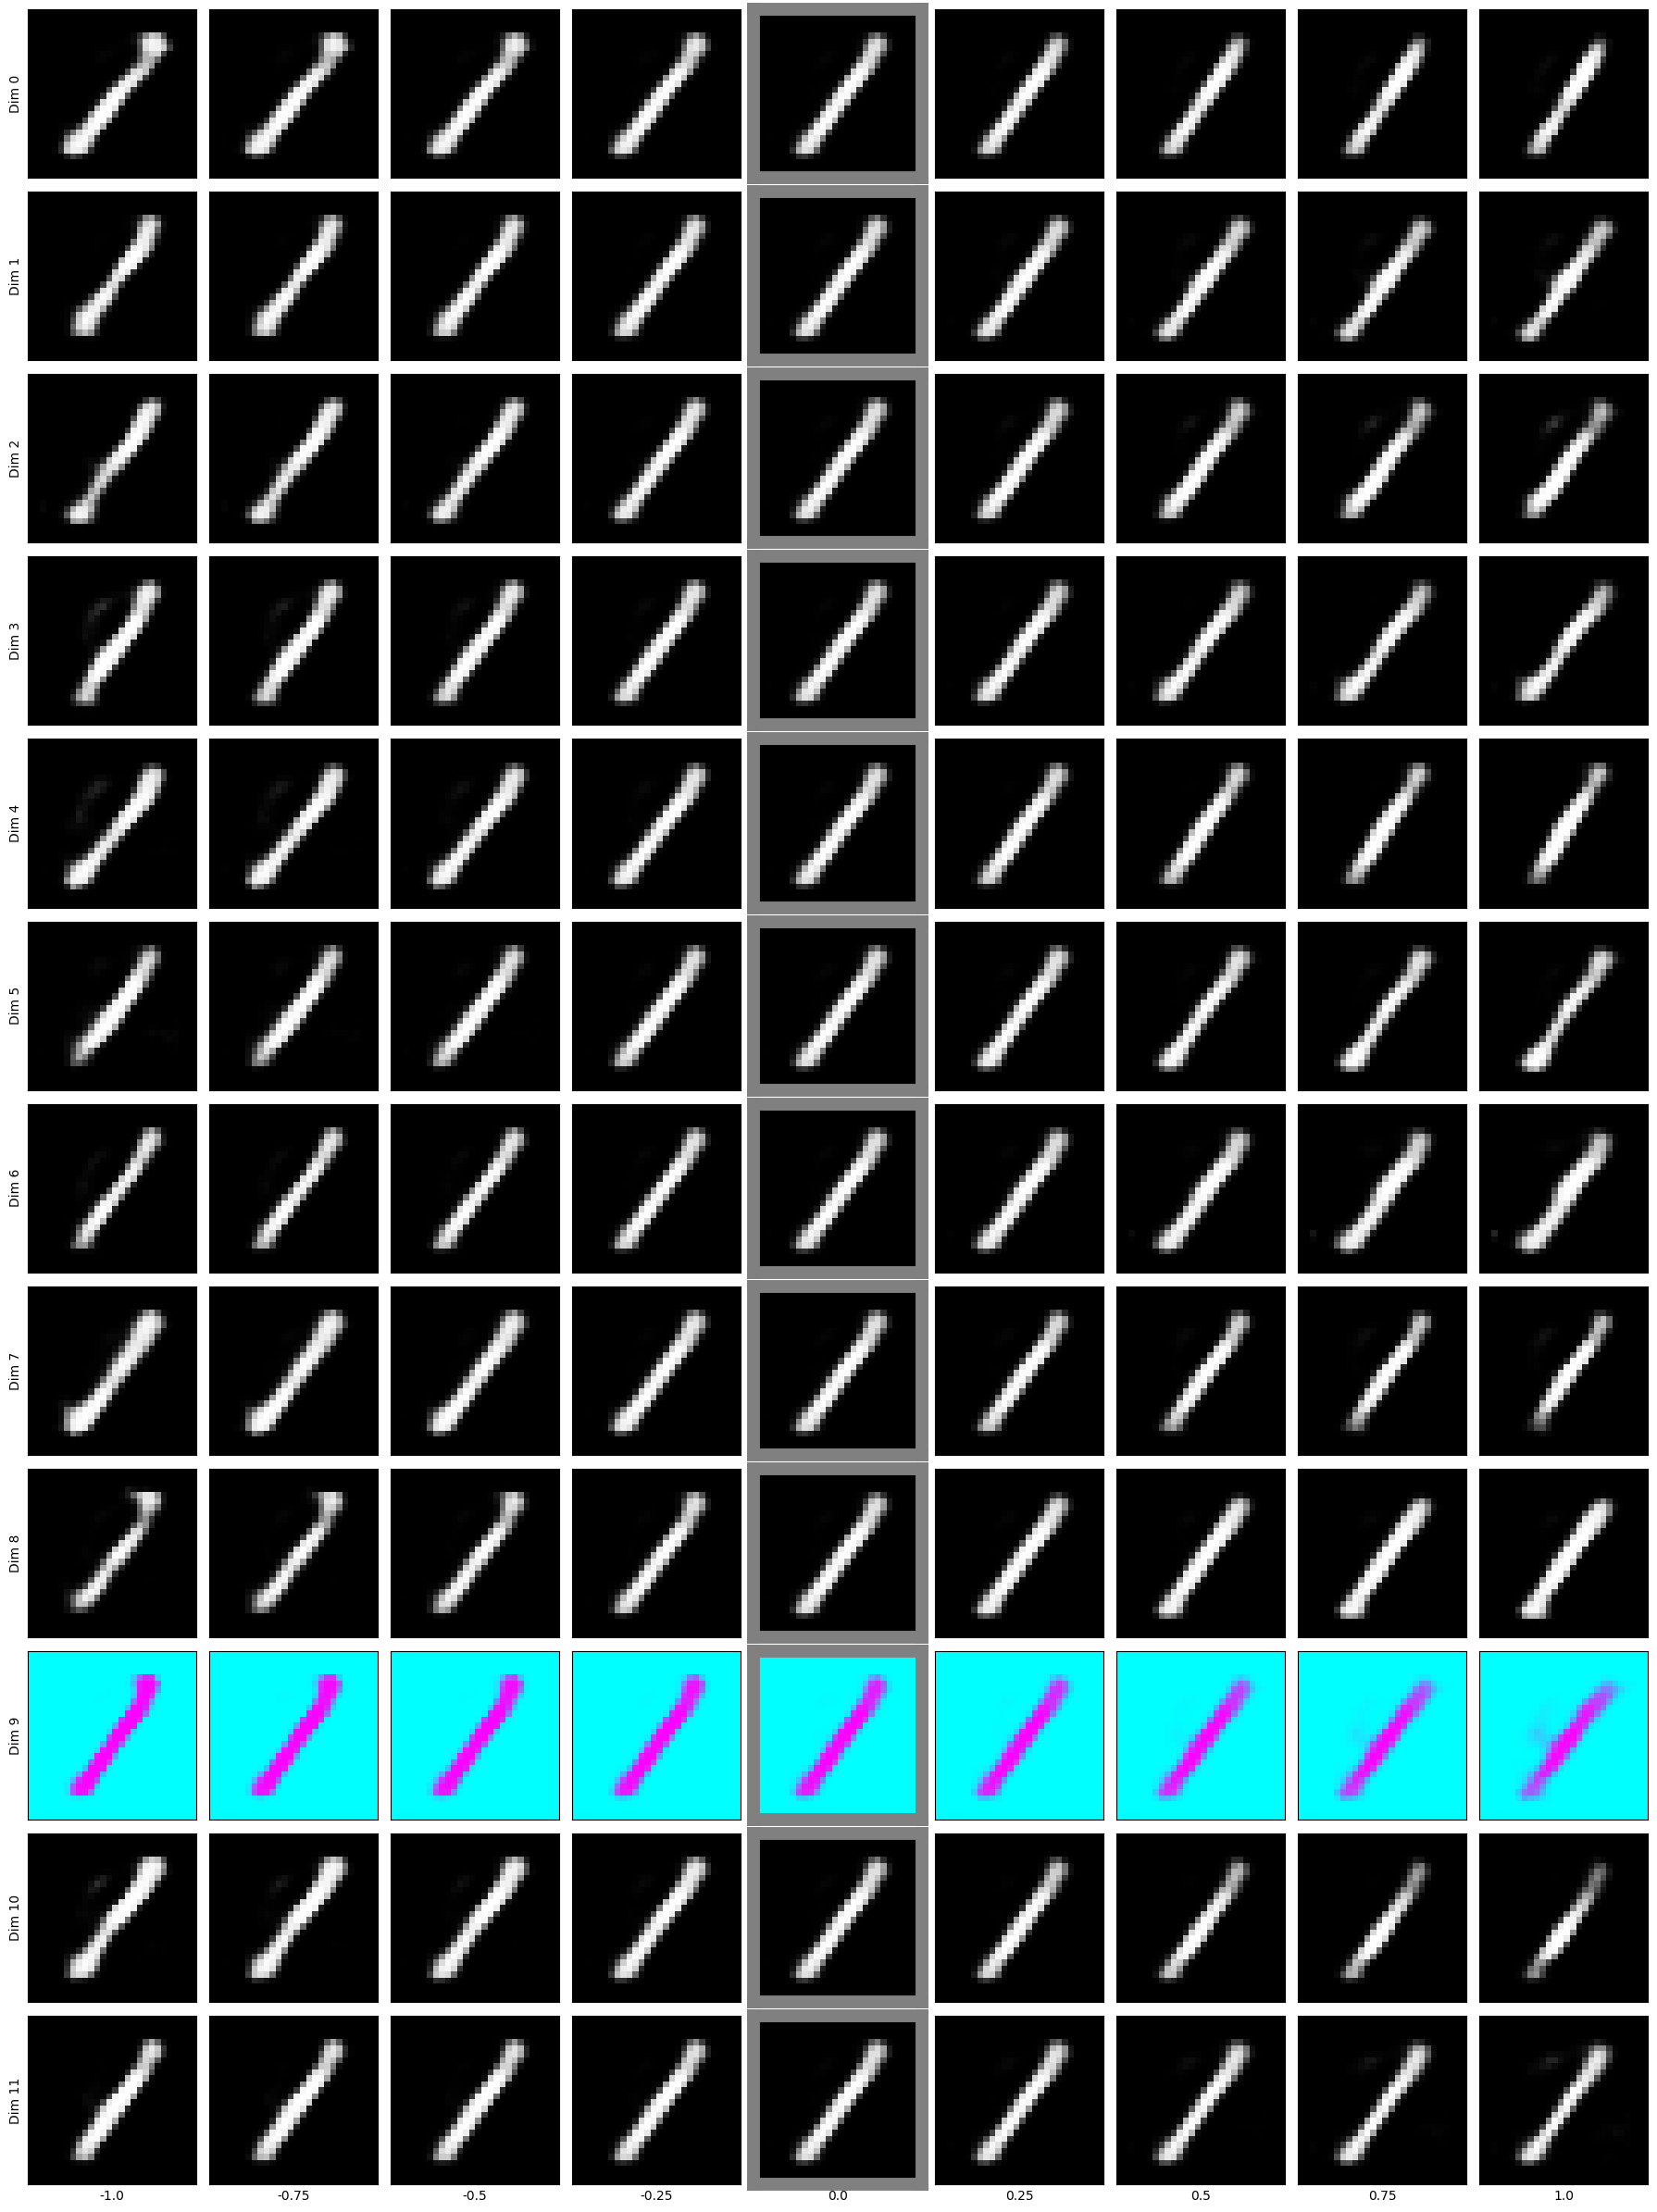

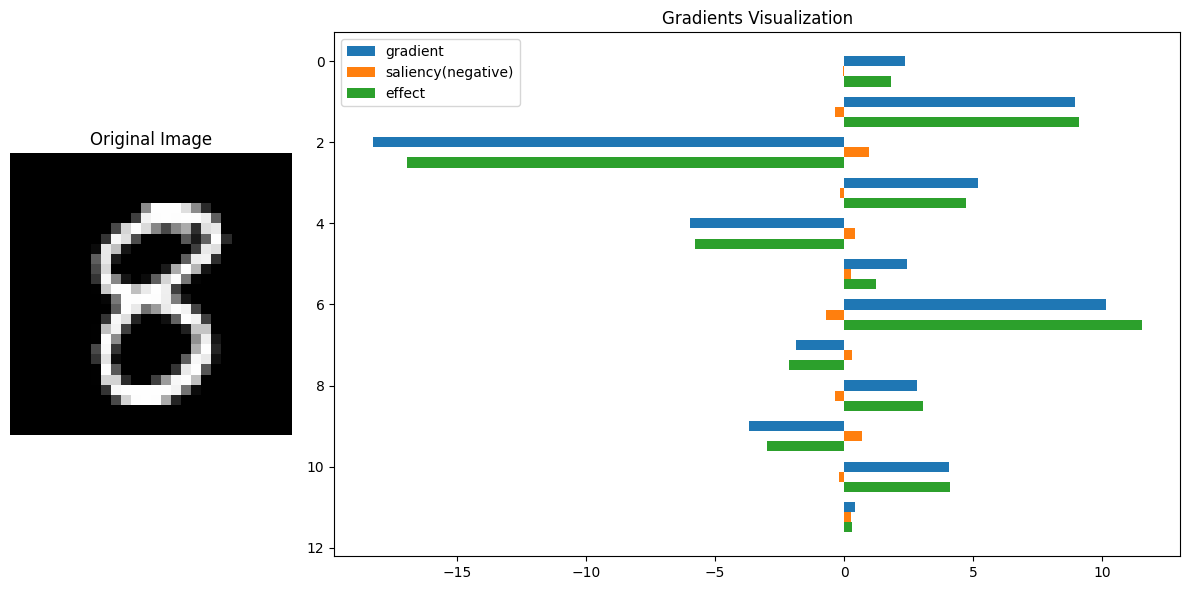

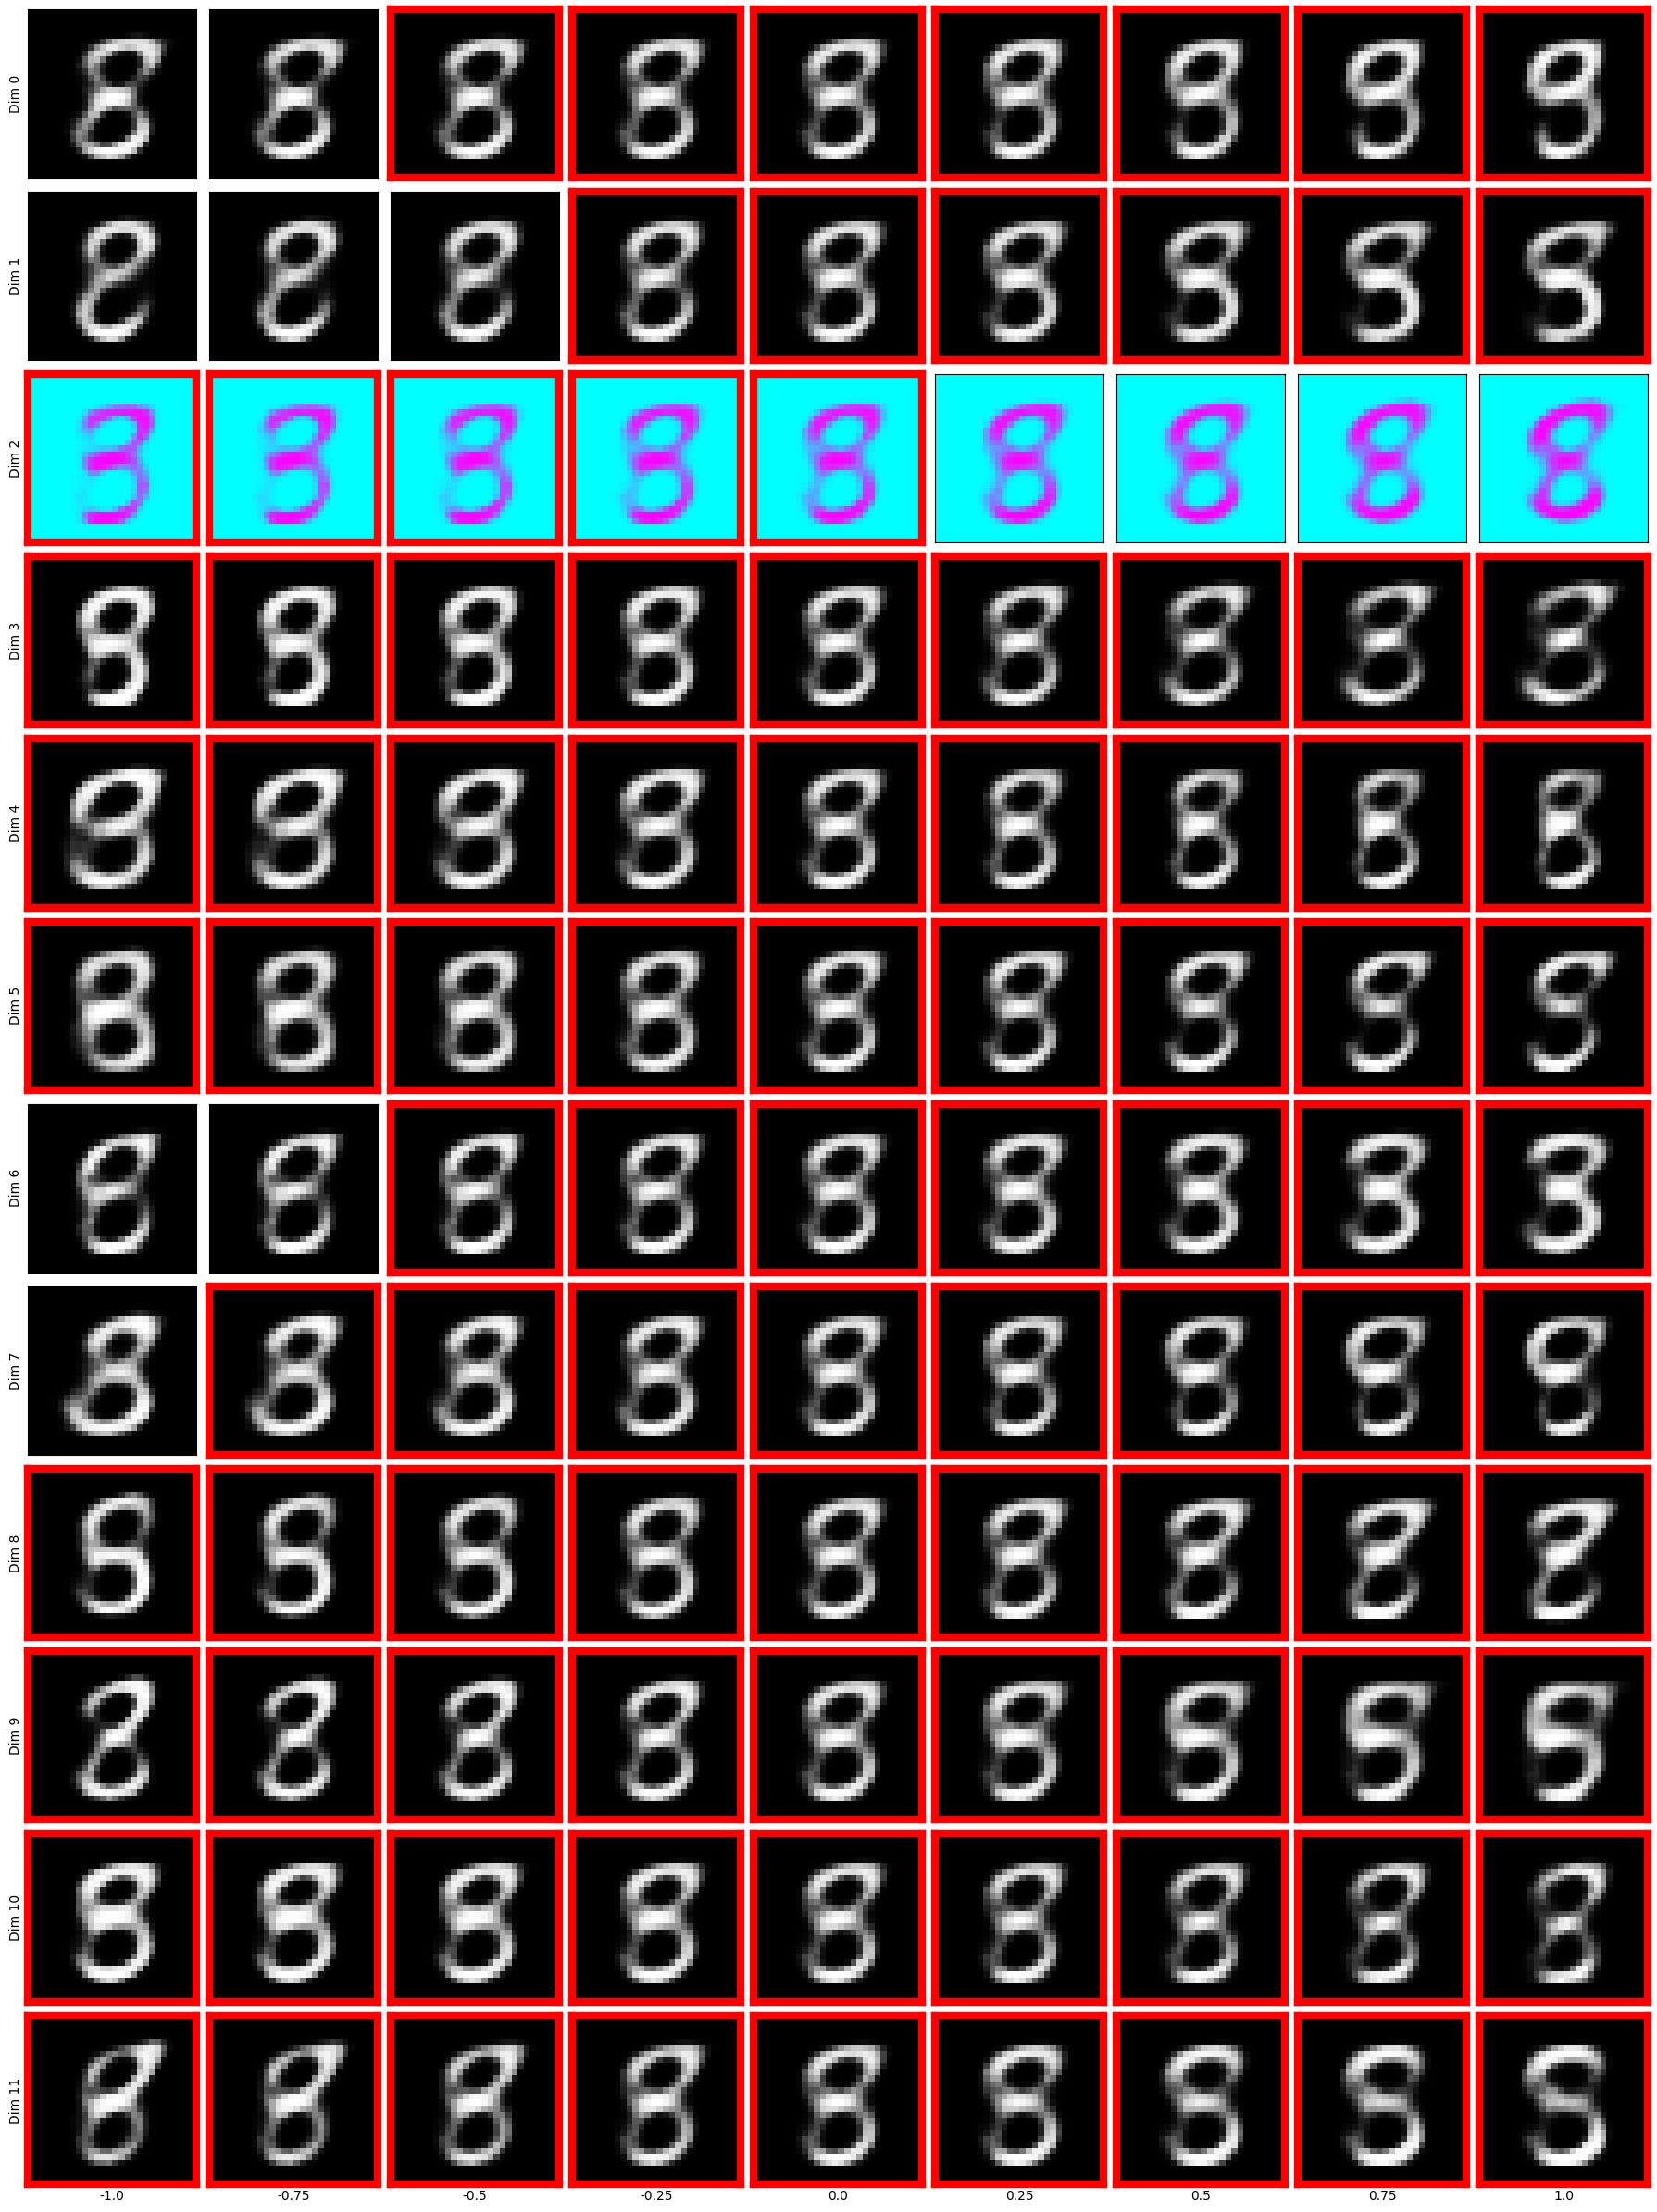

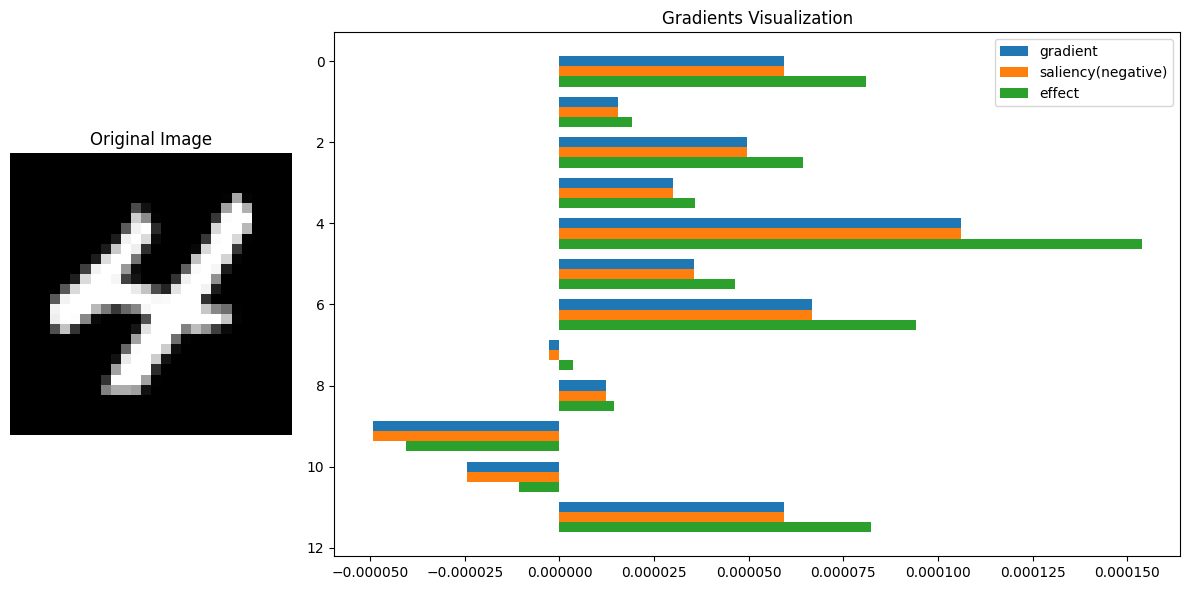

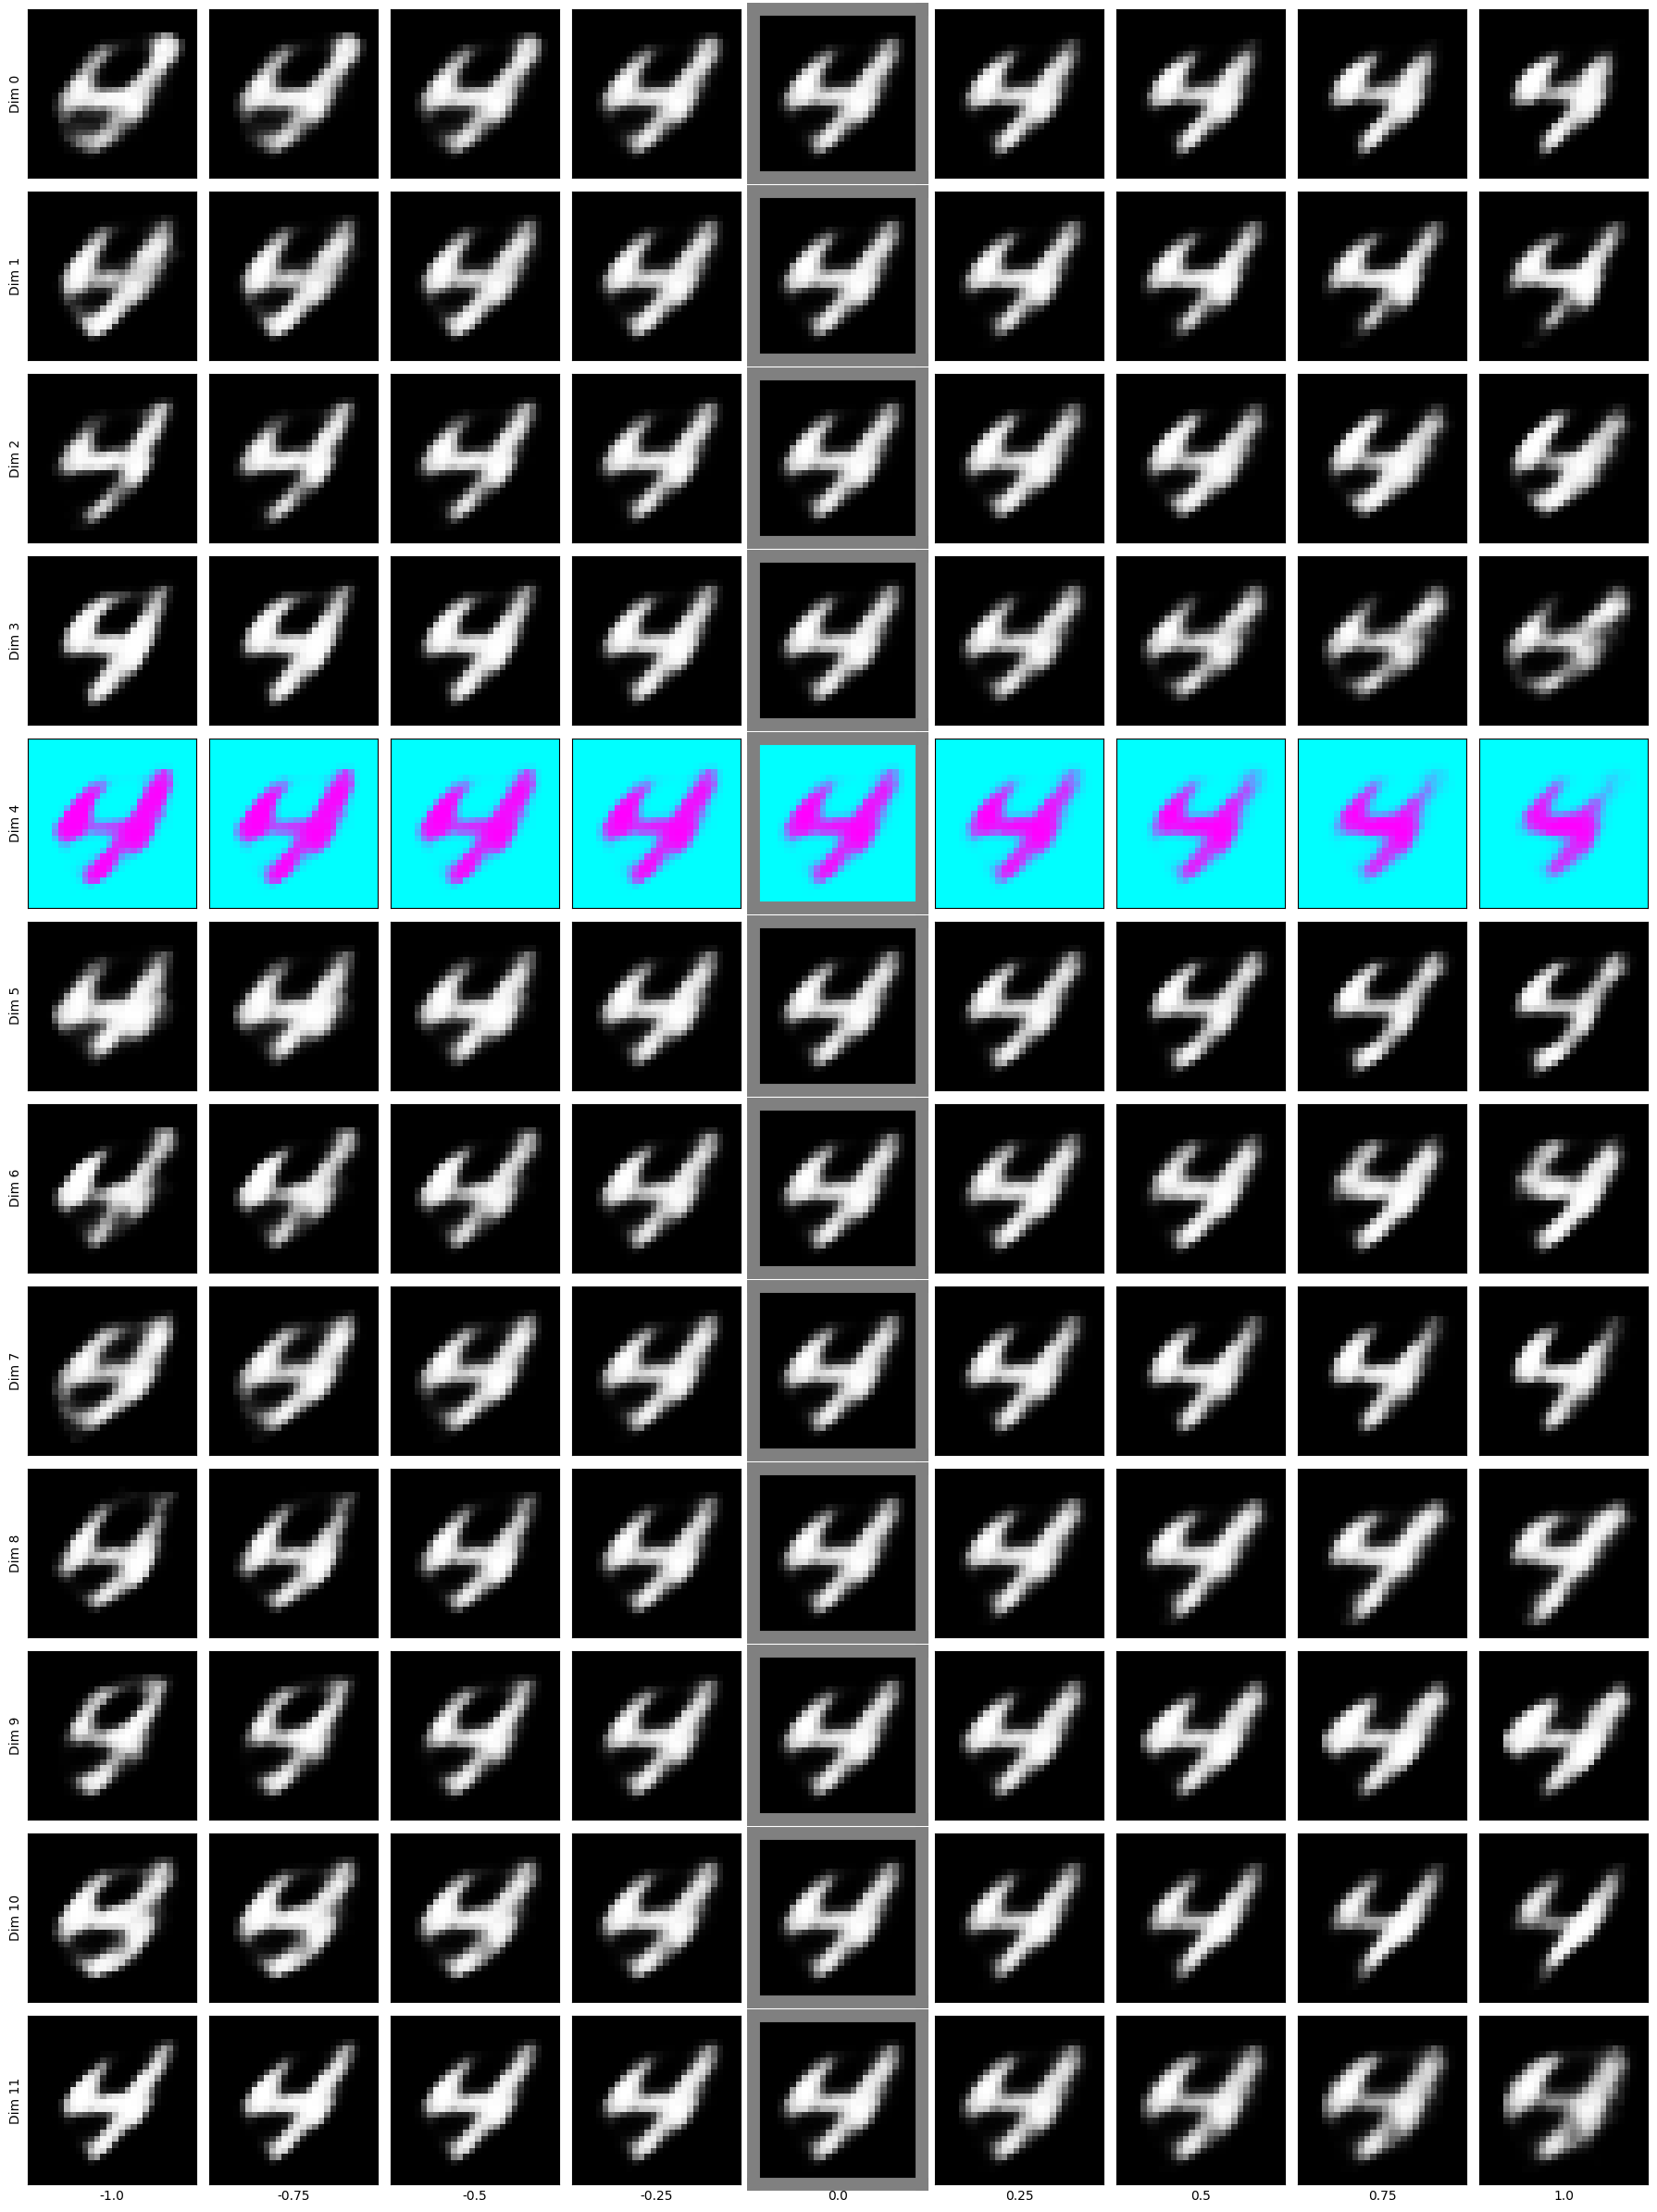

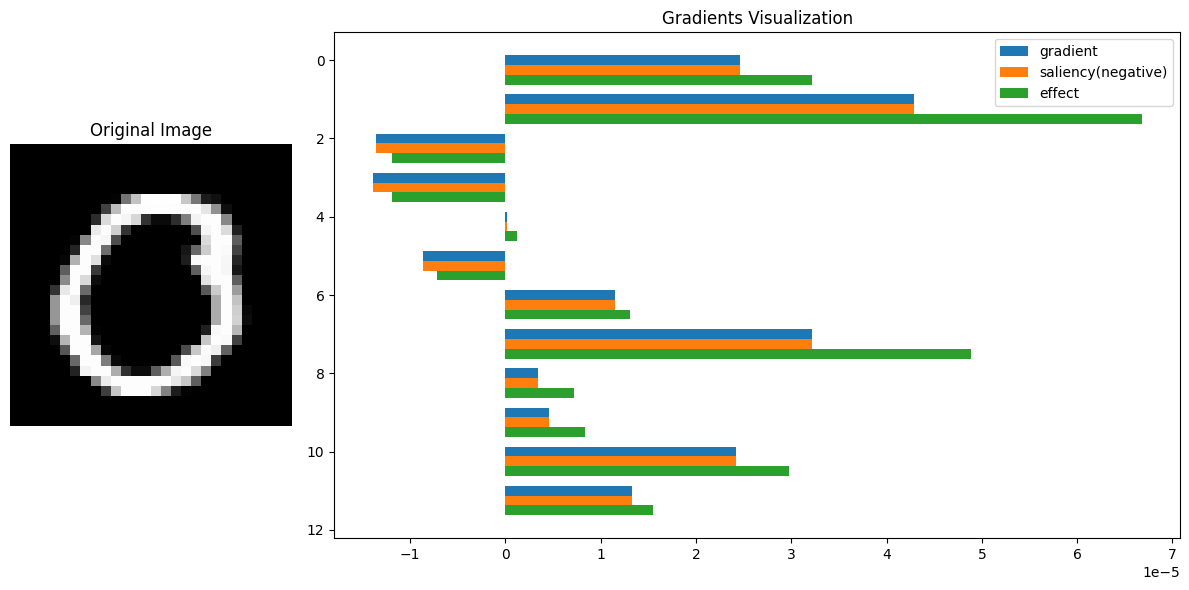

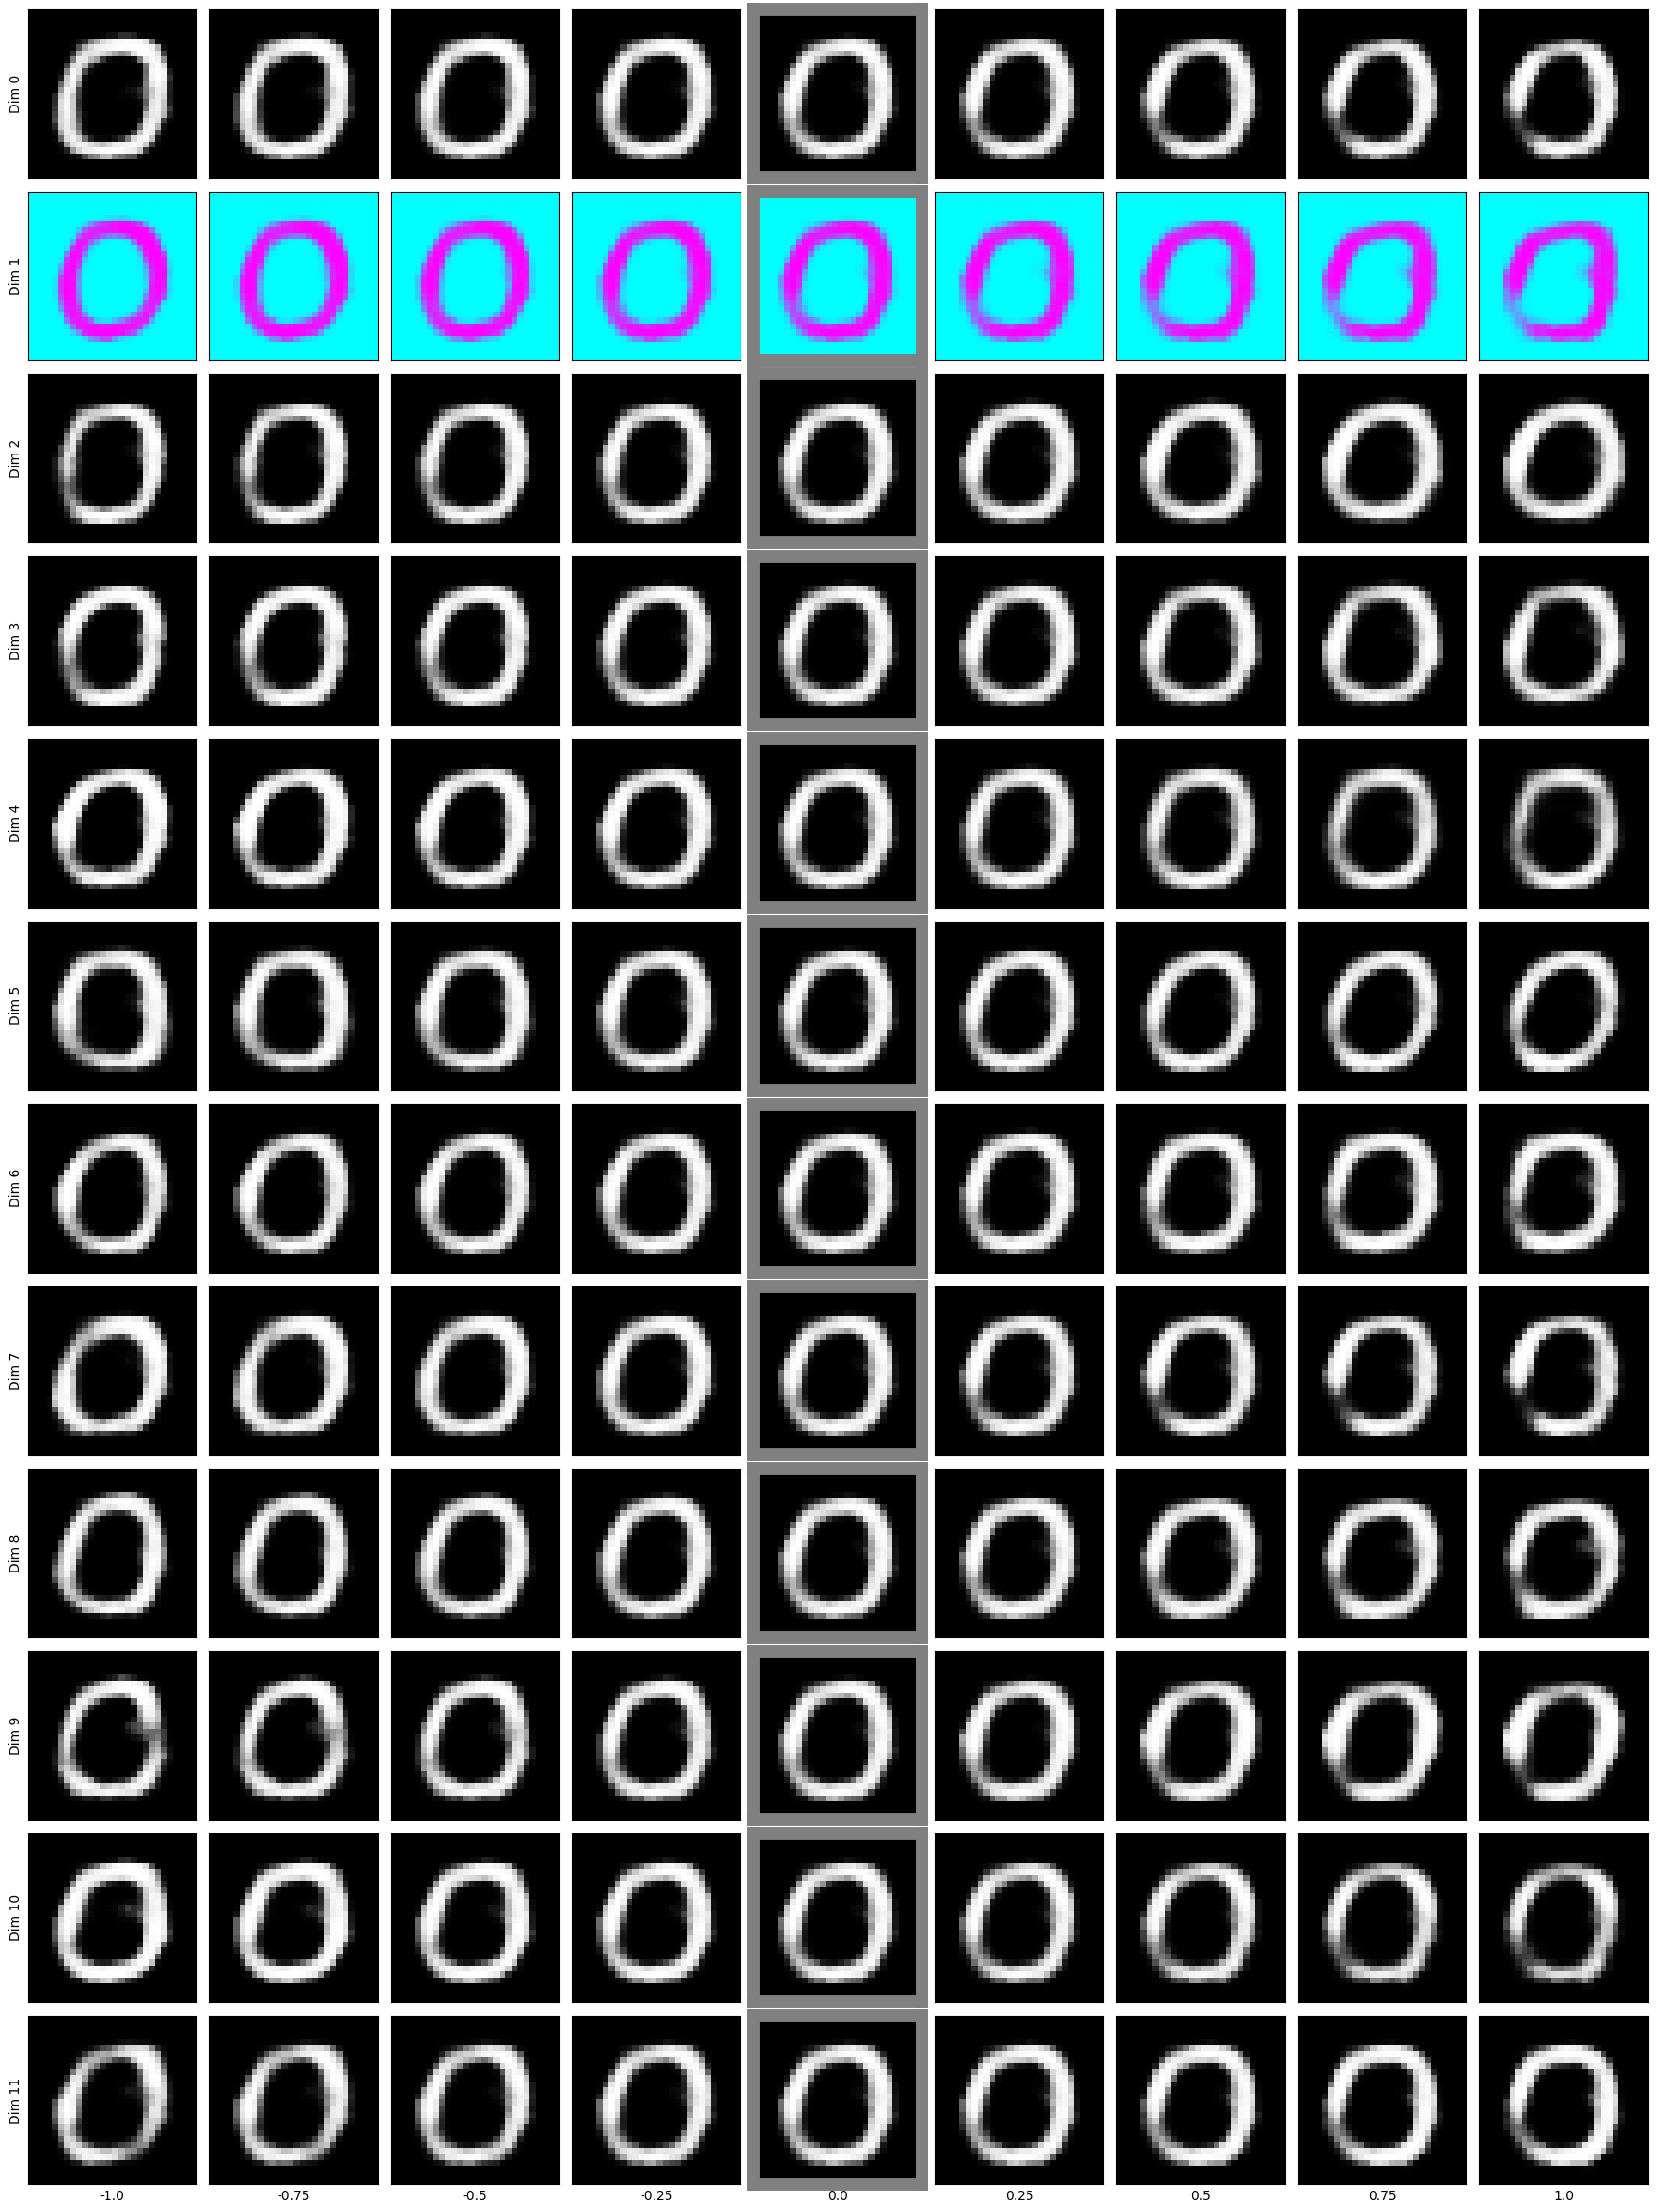

In [7]:
    count = 10
    for i in range(len(x_view)):
        x = np.array([h_view[i]])
        y = np.array([y_view_onehot[i]])
        g = gradient_of_x(x, y, xai)
        g2 = saliency_of_x(x, xai)
        g3 = effect_of_x(x, y, xai, delta=0.1)

        g_npy = np.squeeze(g.numpy())
        g_npy2 = np.squeeze(g2.numpy())
        g_npy3 = g3
        plot_image_and_gradients(np.reshape(x_view[i], (28, 28)), [g_npy, -g_npy2, g_npy3], ["gradient", "saliency(negative)", "effect"])

        # Identify the maximum gradient entry
        max_grad_index = np.argmax(np.abs(g_npy))
        # latent_space_display(x, vae.decoder, highlight_dim=max_grad_index)
        latent_space_display_mark(x, view_sample_labels[i], vae.decoder, xai, highlight_dim=int(max_grad_index))

        if count <= 0:
            break
        count -= 1